# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_FROZEN.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_STD.x': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY.x': 'object',  # two entries that at 3?, (also 1 that is 44), convert to numeric, coerce errors
    'GONAD_WEIGHT': 'object',  # some '.' / 'NA', convert to numeric, coerce error to make 'NA' actually null
    'Ager.1': 'object',
    'AGE.1': 'object',  # convert to numeric and separate text comments
    'FSP.1': 'object',  # convert to numeric and separate text comments
    'Comments.1': 'object', 
    'Ager.2': 'object',  
    'AGE.2': 'object',  # convert to numeric and separate text comments
    'FSP.2': 'object',  # convert to numeric and separate text comments
    'Comments.2': 'object', 
    'Ager.3': 'object', 
    'AGE.3': 'object',  # convert to numeric and separate text comments
    'FSP.3': 'object',  # convert to numeric and separate text comments
    'Comments.3': 'object', 
    'Envelop Comments': 'object'
} 

df_FD = pd.read_excel('Gaspereau Ages_Combined.xlsx', dtype=dtypes)

In [3]:
# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes_1'] = df_FD['AGE.1']
df_FD['FSP_notes_1'] = df_FD['FSP.1']
df_FD['AGE_notes_2'] = df_FD['AGE.2']
df_FD['FSP_notes_2'] = df_FD['FSP.2']
df_FD['AGE_notes_3'] = df_FD['AGE.3']
df_FD['FSP_notes_3'] = df_FD['FSP.3']

# convert to numeric and coerce errors
# for FL_WET.x, one measurement is a float (258.8), all else are int, need to round to convert to int
df_FD['FL_WET.x'] = np.round(pd.to_numeric(df_FD['FL_WET.x'], errors='coerce')).astype('Int32')
df_FD['FL_FROZEN.x'] = pd.to_numeric(df_FD['FL_FROZEN.x'], errors='coerce').astype('Int32')
df_FD['MATURITY.x'] = pd.to_numeric(df_FD['MATURITY.x'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')
df_FD['AGE.2'] = pd.to_numeric(df_FD['AGE.2'], errors='coerce').astype('Int32')
df_FD['FSP.2'] = pd.to_numeric(df_FD['FSP.2'], errors='coerce').astype('Int32')
df_FD['AGE.3'] = pd.to_numeric(df_FD['AGE.3'], errors='coerce').astype('Int32')
df_FD['FSP.3'] = pd.to_numeric(df_FD['FSP.3'], errors='coerce').astype('Int32')

# rename keys with '.' for ease of use within pandas
rename_FD = {
    'FL_WET.x': 'FL_WET', 
    'FL_FROZEN.x': 'FL_FROZEN',
    'FL_STD.x': 'FL_STD', 
    'MATURITY.x': 'MATURITY',
    'Ager.1': 'Ager_1',
    'AGE.1': 'AGE_1',
    'FSP.1': 'FSP_1',
    'Comments.1': 'Comments_1',
    'Ager.2': 'Ager_2',
    'AGE.2': 'AGE_2',
    'FSP.2': 'FSP_2',
    'Comments.2': 'Comments_2',
    'Ager.3': 'Ager_3',
    'AGE.3': 'AGE_3',
    'FSP.3': 'FSP_3',
    'Comments.3': 'Comments_3'
}
df_FD = df_FD.drop('Unnamed: 0', axis=1).rename(columns=rename_FD)

In [4]:
# create a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

# move the DATETIME column to the front of the dataframe
df_FD = df_FD[['DATETIME'] + [col for col in df_FD.columns if col != 'DATETIME']]

### Clean, Backup, Remap, and Take 1st Entry for Site, convert to int (temp for processing)

In [5]:
# clean the site column before investigating in detail

# backup exact site entries as site notes
df_FD['SITE_notes'] = df_FD['SITE'].astype('str')

# Expand and Clean Site Column
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE.astype('str').str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

# these are the non-numeric entries to be remapped
[x for x in list(df_FD.SITE1.unique()) if not x.isnumeric()]

['nan',
 '1A',
 '47or62',
 '11K3(435',
 'E.MACFARLANE',
 'EricMacFarlane',
 'JMcFarlane',
 'JACoady',
 'EricMac']

In [6]:
# remap sites to numeric, overwrite SITE (after backing up notes), convert to integer

# these indices/numbers are important/exact, but will be undone on import to dm_apps
# these are consistent with older analysis, other tables, and import script into dm_apps
remap_sites = {
    '1A': 90,
    '1B': 91,
    '47or62': 47,
    'EricMcFarlane': 92,
    'E.MACFARLANE': 92,
    'EricMacFarlane': 92,
    'EricMac': 92,
    'JimmyMacFarlane': 93,
    'JMcFarlane': 93,
    'JohnAlbertCoady': 94,
    'JACoady': 94,
    '11K3(435': 95
}

df_FD['SITE'] = df_FD.replace({'SITE1': remap_sites}).SITE1
df_FD['SITE'] = pd.to_numeric(df_FD['SITE'], errors='coerce').astype('Int32')

# Descriptive Statistics

In [7]:
df_FD.dtypes

DATETIME            datetime64[ns]
YEAR                         Int32
MM                           Int32
DD                           Int32
WEEK                         Int32
SITE                         Int32
PERIOD                      object
CONDITION                   object
FISH_NO                      Int32
FL_WET                       Int32
FL_FROZEN                    Int32
FL_STD                     float64
WEIGHT                     float64
SPECIES                     object
SEX                         object
MATURITY                     Int32
GONAD_WEIGHT               float64
Ager_1                      object
AGE_1                        Int32
FSP_1                        Int32
Comments_1                  object
Ager_2                      object
AGE_2                        Int32
FSP_2                        Int32
Comments_2                  object
Ager_3                      object
AGE_3                        Int32
FSP_3                        Int32
Comments_3          

In [8]:
df_FD.describe(include='all', datetime_is_numeric=False).T

C:\Users\CARRK\AppData\Local\Temp\1\ipykernel_7236\503964342.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_FD.describe(include='all', datetime_is_numeric=False).T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DATETIME,36912,783,1996-06-05 00:00:00,158,1983-05-09,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YEAR,36912.000,NaN,NaN,NaN,NaT,NaT,2001.600,11.430,1983.000,1990.000,2000.000,2012.000,2021.000
MM,36912.000,NaN,NaN,NaN,NaT,NaT,5.403,0.502,4.000,5.000,5.000,6.000,7.000
DD,36912.000,NaN,NaN,NaN,NaT,NaT,16.133,8.764,1.000,9.000,16.000,24.000,31.000
WEEK,23664.000,NaN,NaN,NaN,NaT,NaT,5.141,2.027,1.000,4.000,5.000,7.000,10.000
SITE,36794.000,NaN,NaN,NaN,NaT,NaT,27.553,18.076,1.000,12.000,26.000,41.000,95.000
PERIOD,31710,4,AM,16927,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONDITION,36717,4,Frozen,25118,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_NO,36912.000,NaN,NaN,NaN,NaT,NaT,17.756,11.620,1.000,9.000,17.000,25.000,100.000
FL_WET,10853.000,NaN,NaN,NaN,NaT,NaT,251.729,20.377,1.000,238.000,251.000,265.000,358.000


# check all of the fields

In [9]:
for col in df_FD.columns:
    print()
    print(col)
    if df_FD[col].nunique() > 100:
        print('number of unique values:', df_FD[col].nunique())
    else:
        print(df_FD[col].unique())


DATETIME
number of unique values: 783

YEAR
<IntegerArray>
[1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996,
 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021]
Length: 37, dtype: Int32

MM
<IntegerArray>
[5, 6, 4, 7]
Length: 4, dtype: Int32

DD
<IntegerArray>
[12, 14, 16, 17, 19, 21, 23, 26, 31,  9,  2, 24, 30,  1, 10, 11, 13, 15, 18,
 20, 22, 25, 27, 28, 29,  3,  4,  6,  7,  8,  5]
Length: 31, dtype: Int32

WEEK
<IntegerArray>
[<NA>, 4, 5, 6, 7, 8, 2, 3, 1, 9, 10]
Length: 11, dtype: Int32

SITE
<IntegerArray>
[  12,   46,    9,   25,   33,    2,   49,   35,   17,   39,   38,    5,    8,
   37,    7,   51,   11,   64,   56, <NA>,   15,   48,   34,    4,   23,   67,
    1,   26,   28,    6,   52,   29,   90,   60,   41,   27,   47,   14,   30,
   62,   95,   92,   93,   94]
Length: 44, dtype: Int32

PERIOD
[nan 'PM' 'AM' 'PM ' 'AD']

CONDITION
['Fresh' 'Frozen' 'F

In [10]:
# most datatypes look good, FL_STD could be an int: could round and convert
# left as is for now
# these look like conversion issues, 4 decimals after mm is unrealistic
df_FD['FL_STD'].sample(1000).unique()

array([229.    , 271.    , 235.    , 236.    , 248.    , 292.    ,
       244.    , 249.    , 268.    , 273.    , 254.    , 251.    ,
       307.    , 276.    , 260.    , 281.    , 246.    , 228.    ,
       266.    , 265.    , 258.    , 238.    , 255.    , 253.    ,
       252.    , 259.    ,      nan,  21.3   , 212.    , 223.    ,
       220.    , 261.    , 237.    , 287.    , 241.    , 263.    ,
       274.    , 264.    , 215.    , 269.    , 280.    , 247.    ,
       314.    , 283.    , 230.    , 257.    , 225.    , 277.    ,
       286.    , 256.    , 240.    , 262.    , 231.    , 289.    ,
       288.    , 250.    , 278.    , 208.    , 270.    , 245.    ,
       234.    , 282.    , 227.    , 243.    , 299.    , 214.    ,
       275.    , 239.    , 216.    , 226.    , 242.    , 294.    ,
       293.    , 284.    , 290.    , 222.6315, 210.    , 285.    ,
       217.    , 267.    , 291.    , 218.    , 233.    , 303.    ,
       213.    , 211.    , 200.    , 309.    , 232.    , 272. 

# Data Visualisation

### helper functions for EDA

In [11]:
def types_of_data(series):
    
    numbers, strings, blanks, n_null = 0, 0, 0, 0
    
    for item in series:
        if pd.isnull(item):
            n_null += 1
        else:
            try:
                float(item)
                numbers += 1
            except (ValueError):
                strings += 1
                if str(item) == ' ' or str(item) == '':
                    blanks += 1
                
    # note: blanks are strings
    return numbers, strings, blanks, n_null


def print_data_info(dataframe, column):
    
    print('\n--------------------------------------------------\nData Info:', column.upper(), '\n')
    
    numbers, strings, blanks, n_null = types_of_data(dataframe[column])
    
    print('UNIQUE numbers, strings, blanks, null =', types_of_data(dataframe[column].unique()))
    print('number of numeric =', numbers)
    print('number of strings =', strings)
    print('number of blanks =', blanks)  # blanks are strings
    print('number of null = ', n_null)
    print('check: ', numbers + strings + n_null, '==', dataframe[column].shape[0])

    
def print_hist(dataframe, column, max_bins=100, colours=(0,2)):
    
    print('\n--------------------------------------------------\nHistogram:', column.upper())
    
    plt.figure(figsize=(14, 4))
    
    n_unique = dataframe[column].nunique()
    if n_unique <= max_bins:
        bins = n_unique
    else:
        bins = max_bins
    
    # if there are too many bins, rotate the text to make it readable
    if bins > 20:
        xrot = 90
    else:
        xrot = 0
        
    is_categorical = dataframe[column].dtype == 'object'
    if is_categorical:
        plot = dataframe[column].astype(str).sort_values().hist(
            bins=bins, xrot=90, color=sns.color_palette()[colours[1]]
        )
    else:
        plot = dataframe[column].hist(
            bins=bins, xrot=0, color=sns.color_palette()[colours[0]]
        )
    
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    plt.show()
    
    
def print_timeseries(dataframe, column, time_column, colours=(1,3)):
    
    print('\n------------------------------------------------\nTime Series:', column.upper(), sep='')
    
    plt.figure(figsize=(14, 4))
    
    # could make the categorical check an input variable, but this just works (albiet super clean)
    try:
        plot = sns.lineplot(
            x = dataframe[time_column].dt.year, 
            y = dataframe[column].astype(float),  # cast int to float or get ValueErrors with IQR (pi 50)
            errorbar = ('pi', 50),  # IQR
            color = sns.color_palette()[colours[0]]
        )
        print('NUMERICAL')  # NOTE: some are actually categorical but stored as an int(eg, site), those averages don't have meaning
    except (ValueError, TypeError):  # categorical variables, can't cast to float
        plot = sns.lineplot(
            x = dataframe[time_column].dt.year, 
            y = dataframe[column].astype(str).sort_values(),
            errorbar = ('pi', 50), 
            color = sns.color_palette()[colours[1]]
        )
        print('CATEGORICAL')  # NOTE: categorical variables treated as ordinal to make plotting possible, averages don't have meaning
       
    
    # show entire dataset time period for all plots
    plot.set_xlim(1982, 2022)
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    
    plt.show()
    
    
def do_EDA_stuff(dataframe, column, date_column='DATETIME'):
    """default of datetime column name 'DATETIME' often used, can be overwritten"""
    print_data_info(dataframe, column)
    print_hist(dataframe, column)
    print_timeseries(dataframe, column, date_column)

In [12]:
dont_plot_these_columns = [
    'DATETIME', 'YEAR', 'MM', 'DD', 'WEEK', 
#     'SITE_notes', 
#     'SITE1', 'SITE2', 'SITE3',
#     'Ager_1', 'Ager_2', 'Ager_3', 
    'Comments_1', 'Comments_2', 'Comments_3', 'Envelop.Comments', 
#     'AGE_notes_1', 'FSP_notes_1', 'AGE_notes_2', 'FSP_notes_2', 'AGE_notes_3', 'FSP_notes_3'
]

# plot these columns
col_to_plot = [x for x in list(df_FD.columns) if x not in dont_plot_these_columns]




Feature:SITE

--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 1)
number of numeric = 36794
number of strings = 0
number of blanks = 0
number of null =  118
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE


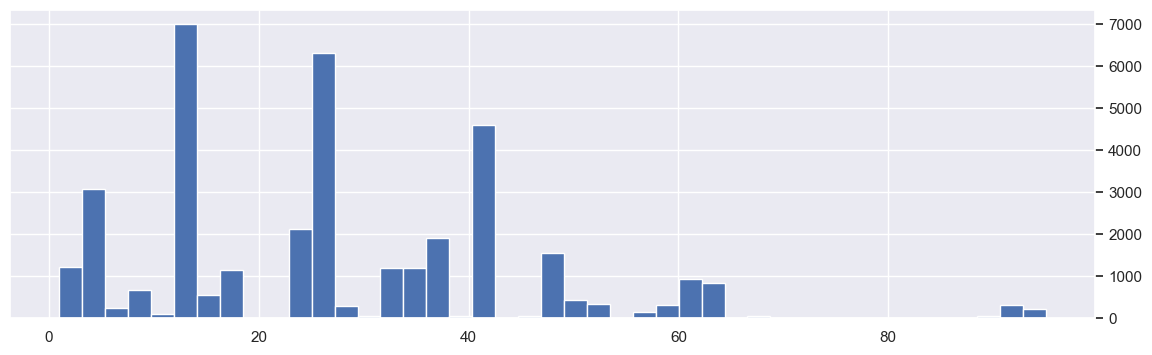


------------------------------------------------
Time Series:SITE
NUMERICAL


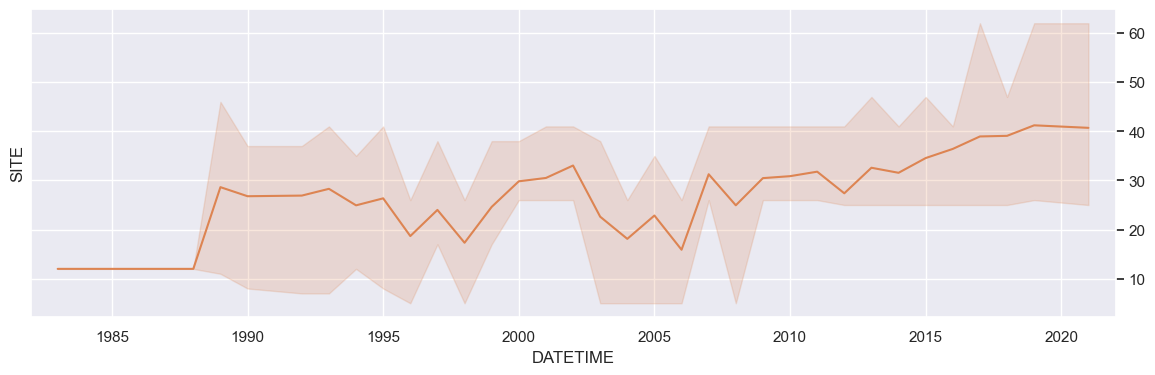




Feature:PERIOD

--------------------------------------------------
Data Info: PERIOD 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 31710
number of blanks = 0
number of null =  5202
check:  36912 == 36912

--------------------------------------------------
Histogram: PERIOD


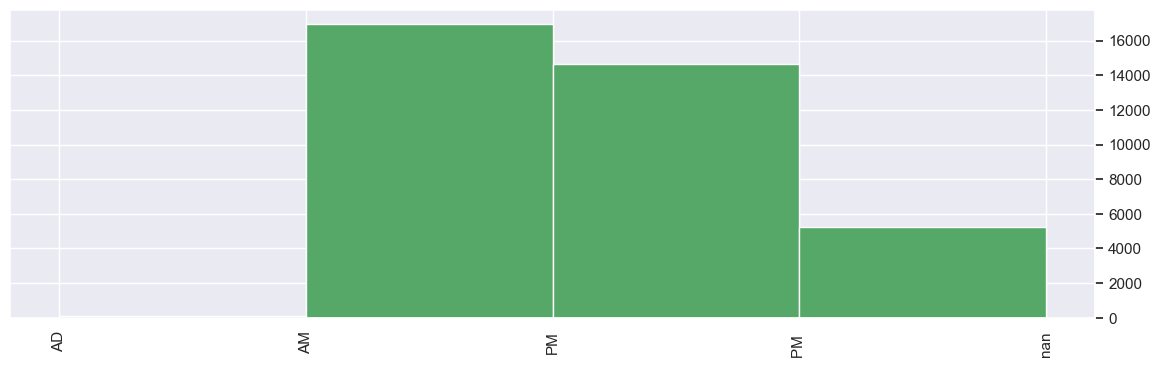


------------------------------------------------
Time Series:PERIOD
CATEGORICAL


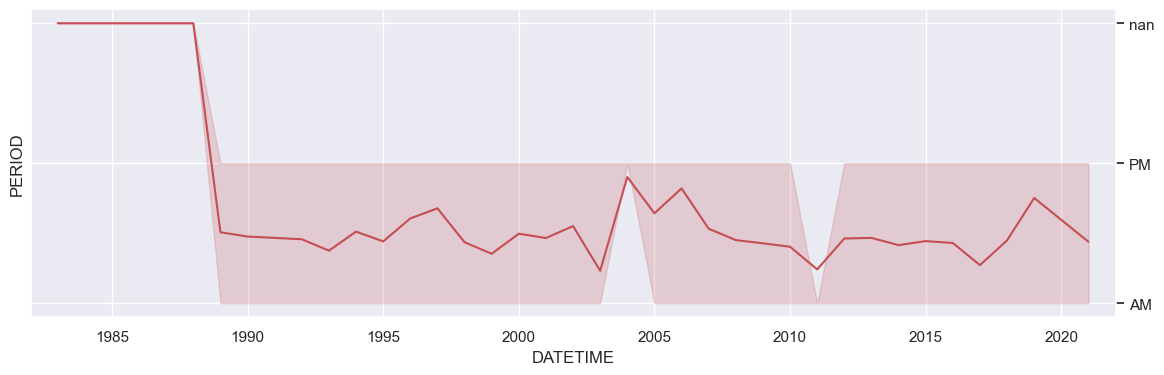




Feature:CONDITION

--------------------------------------------------
Data Info: CONDITION 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 36717
number of blanks = 0
number of null =  195
check:  36912 == 36912

--------------------------------------------------
Histogram: CONDITION


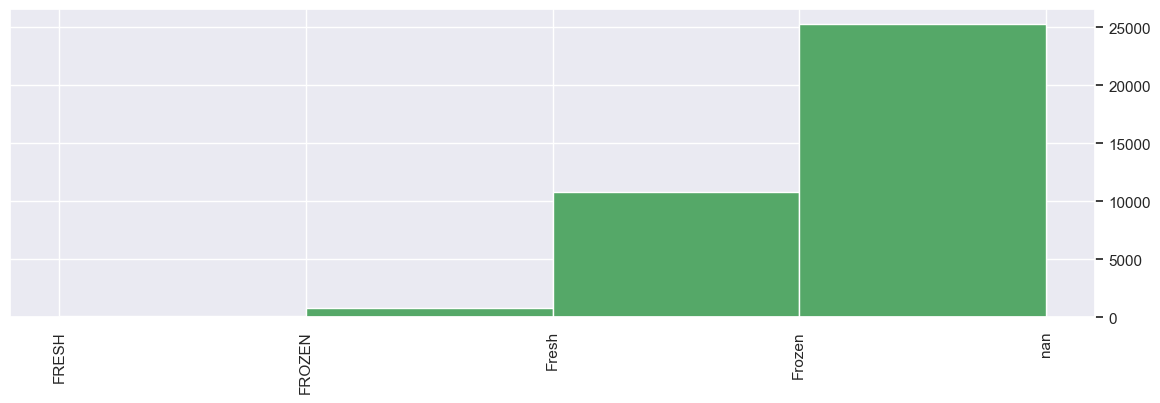


------------------------------------------------
Time Series:CONDITION
CATEGORICAL


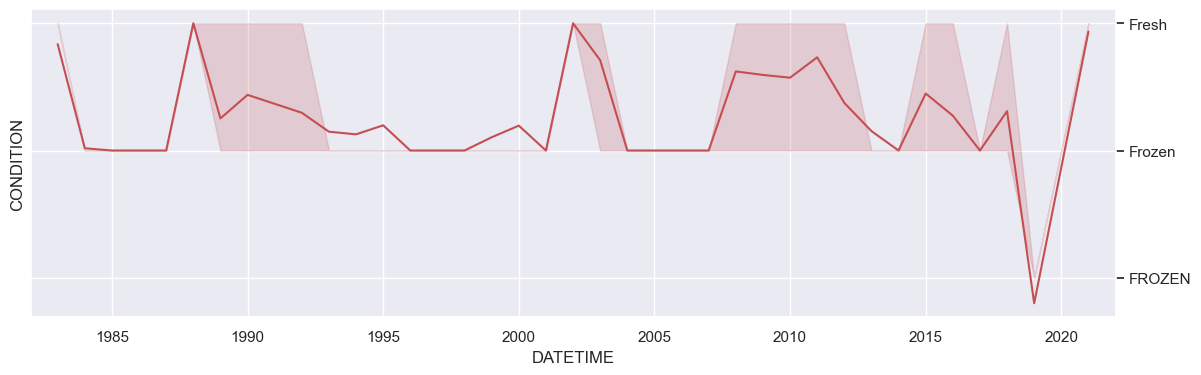




Feature:FISH_NO

--------------------------------------------------
Data Info: FISH_NO 

UNIQUE numbers, strings, blanks, null = (100, 0, 0, 0)
number of numeric = 36912
number of strings = 0
number of blanks = 0
number of null =  0
check:  36912 == 36912

--------------------------------------------------
Histogram: FISH_NO


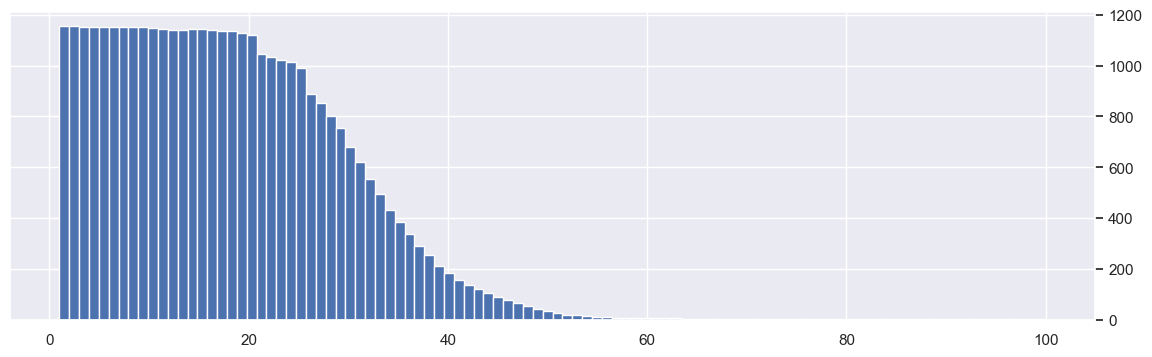


------------------------------------------------
Time Series:FISH_NO
NUMERICAL


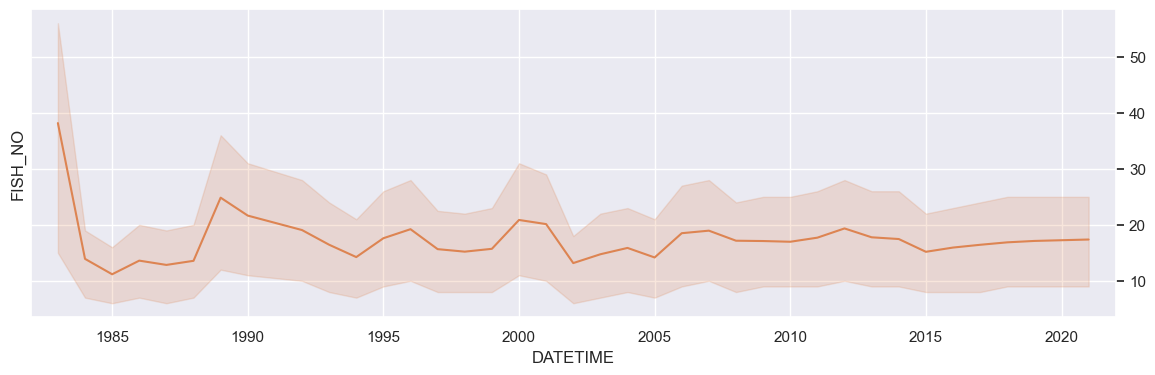




Feature:FL_WET

--------------------------------------------------
Data Info: FL_WET 

UNIQUE numbers, strings, blanks, null = (123, 0, 0, 1)
number of numeric = 10853
number of strings = 0
number of blanks = 0
number of null =  26059
check:  36912 == 36912

--------------------------------------------------
Histogram: FL_WET


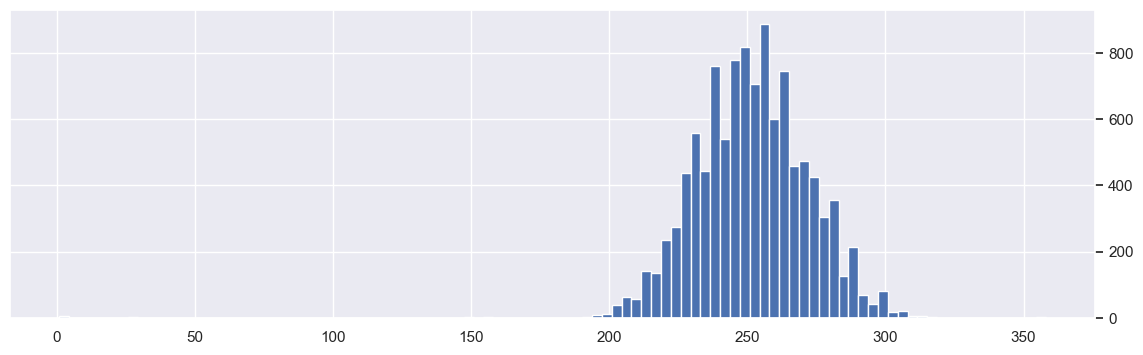


------------------------------------------------
Time Series:FL_WET
NUMERICAL


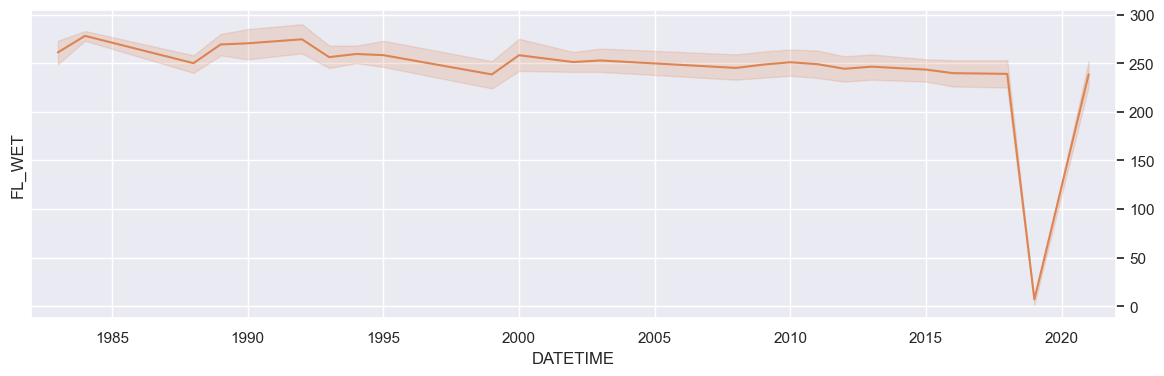




Feature:FL_FROZEN

--------------------------------------------------
Data Info: FL_FROZEN 

UNIQUE numbers, strings, blanks, null = (145, 0, 0, 1)
number of numeric = 25595
number of strings = 0
number of blanks = 0
number of null =  11317
check:  36912 == 36912

--------------------------------------------------
Histogram: FL_FROZEN


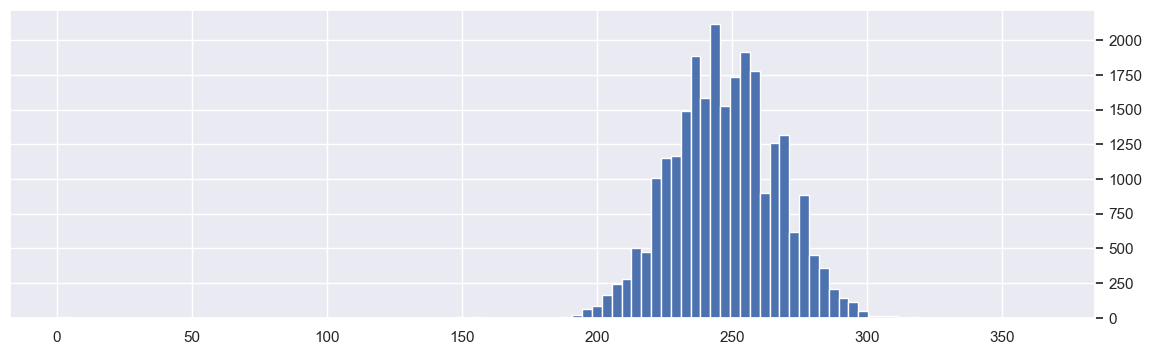


------------------------------------------------
Time Series:FL_FROZEN
NUMERICAL


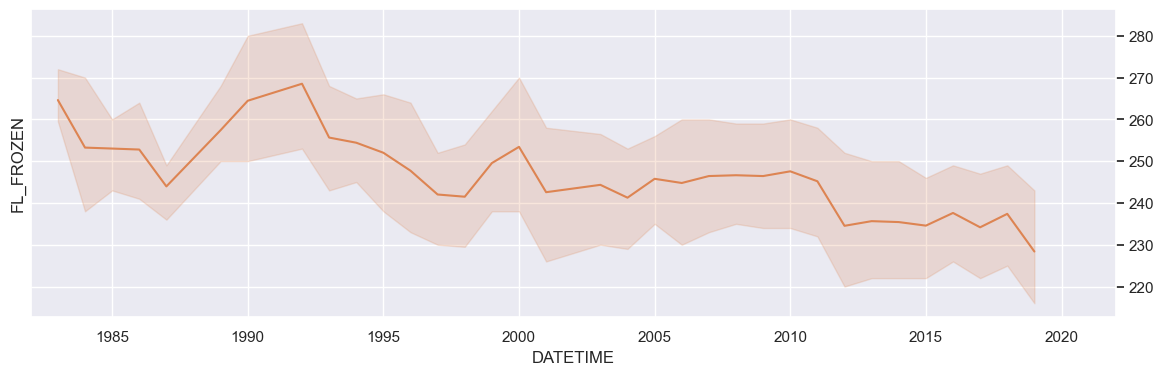




Feature:FL_STD

--------------------------------------------------
Data Info: FL_STD 

UNIQUE numbers, strings, blanks, null = (294, 0, 0, 1)
number of numeric = 35245
number of strings = 0
number of blanks = 0
number of null =  1667
check:  36912 == 36912

--------------------------------------------------
Histogram: FL_STD


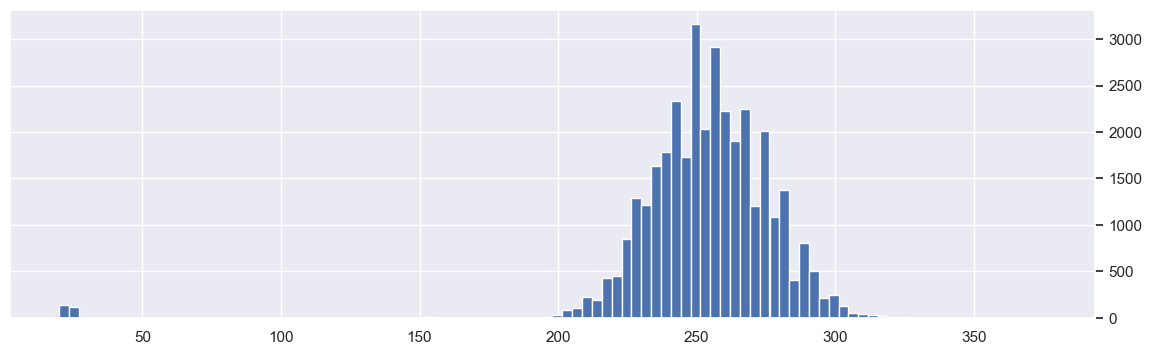


------------------------------------------------
Time Series:FL_STD
NUMERICAL


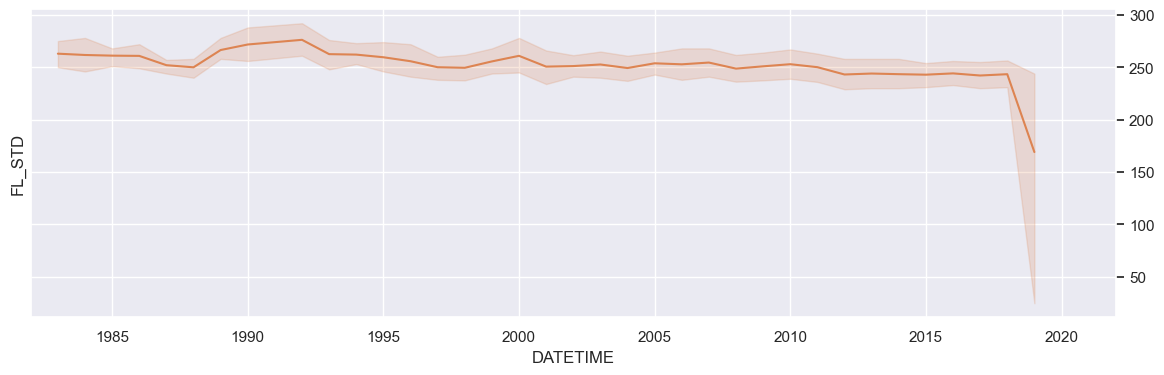




Feature:WEIGHT

--------------------------------------------------
Data Info: WEIGHT 

UNIQUE numbers, strings, blanks, null = (2718, 0, 0, 1)
number of numeric = 36610
number of strings = 0
number of blanks = 0
number of null =  302
check:  36912 == 36912

--------------------------------------------------
Histogram: WEIGHT


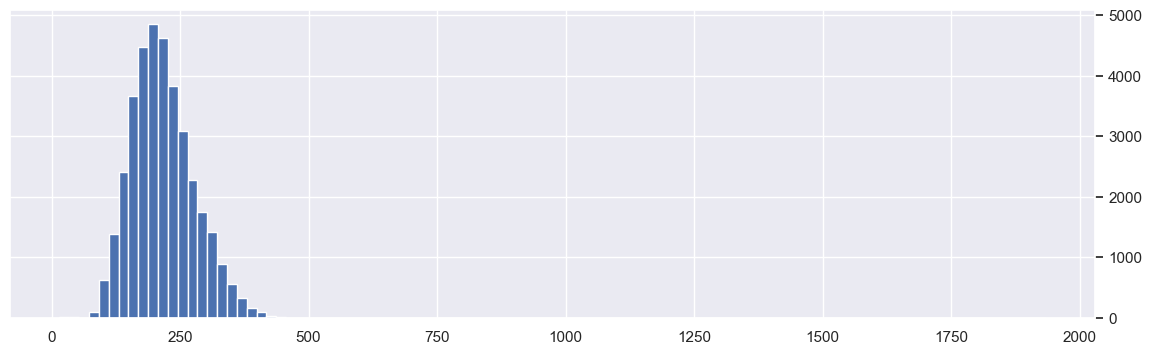


------------------------------------------------
Time Series:WEIGHT
NUMERICAL


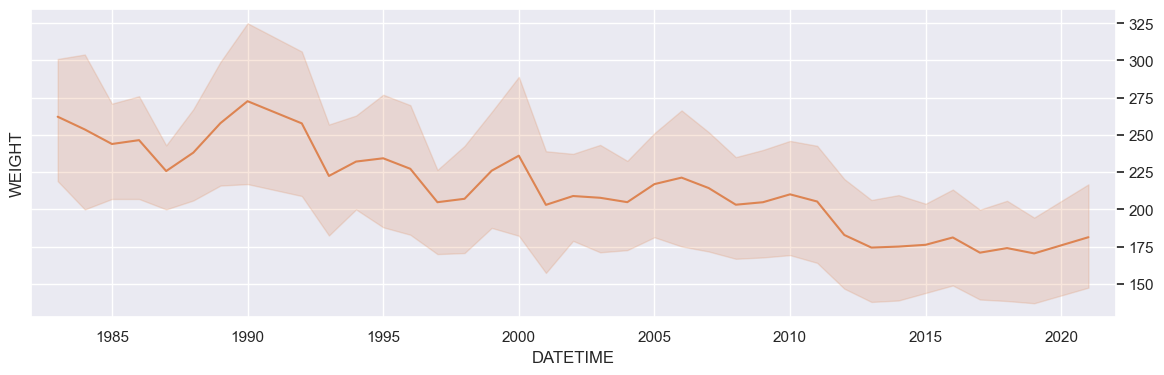




Feature:SPECIES

--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 36685
number of blanks = 0
number of null =  227
check:  36912 == 36912

--------------------------------------------------
Histogram: SPECIES


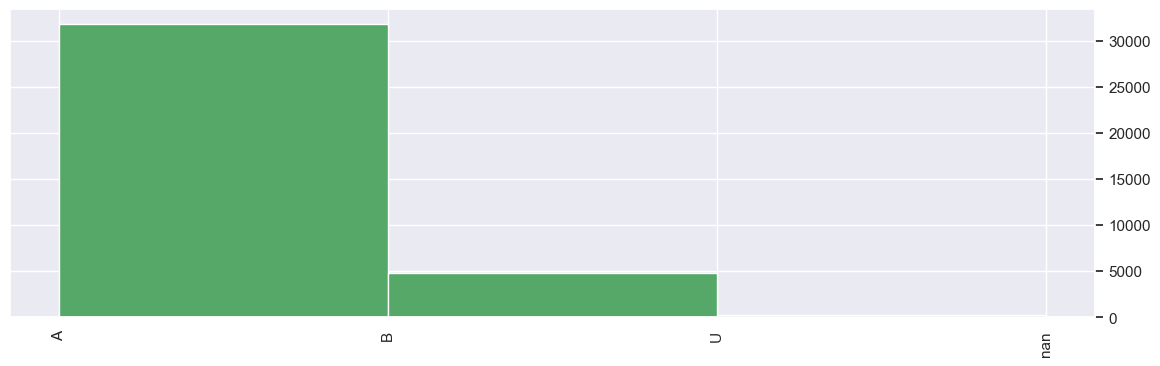


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


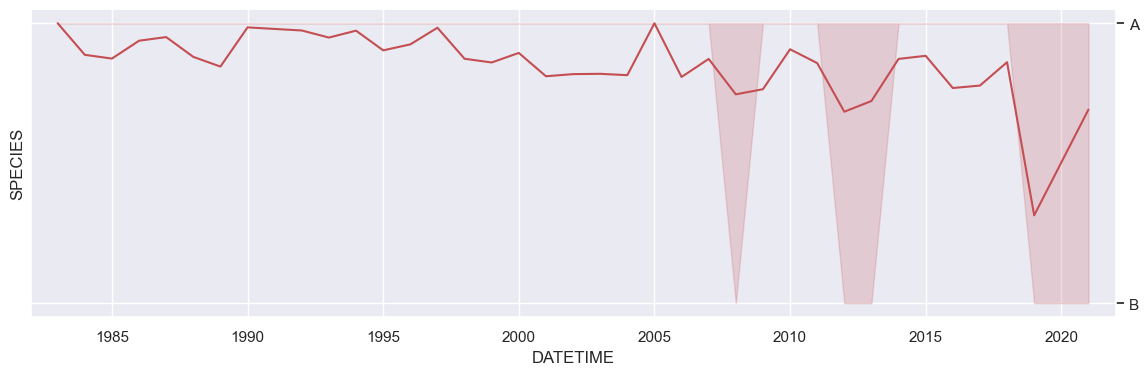




Feature:SEX

--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 5, 0, 1)
number of numeric = 0
number of strings = 36685
number of blanks = 0
number of null =  227
check:  36912 == 36912

--------------------------------------------------
Histogram: SEX


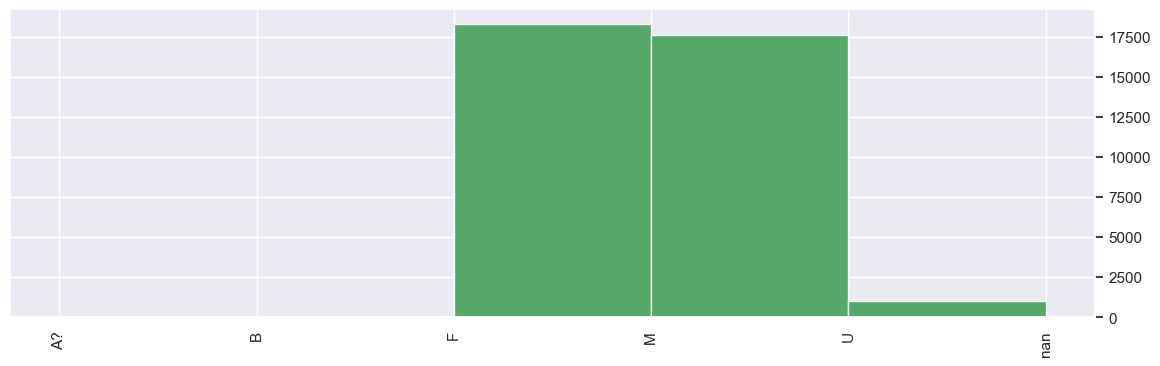


------------------------------------------------
Time Series:SEX
CATEGORICAL


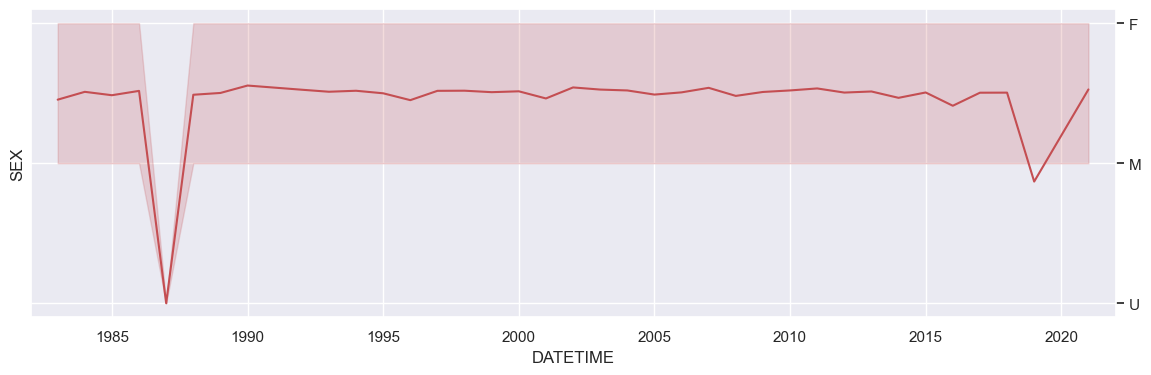




Feature:MATURITY

--------------------------------------------------
Data Info: MATURITY 

UNIQUE numbers, strings, blanks, null = (8, 0, 0, 1)
number of numeric = 36286
number of strings = 0
number of blanks = 0
number of null =  626
check:  36912 == 36912

--------------------------------------------------
Histogram: MATURITY


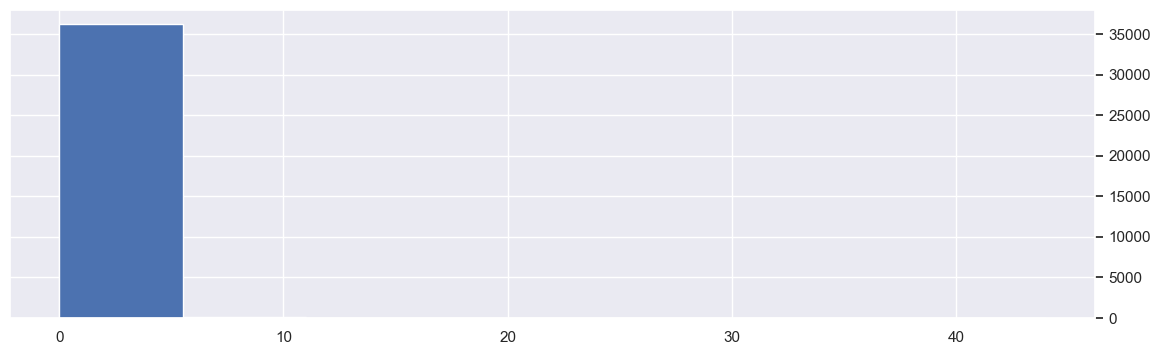


------------------------------------------------
Time Series:MATURITY
NUMERICAL


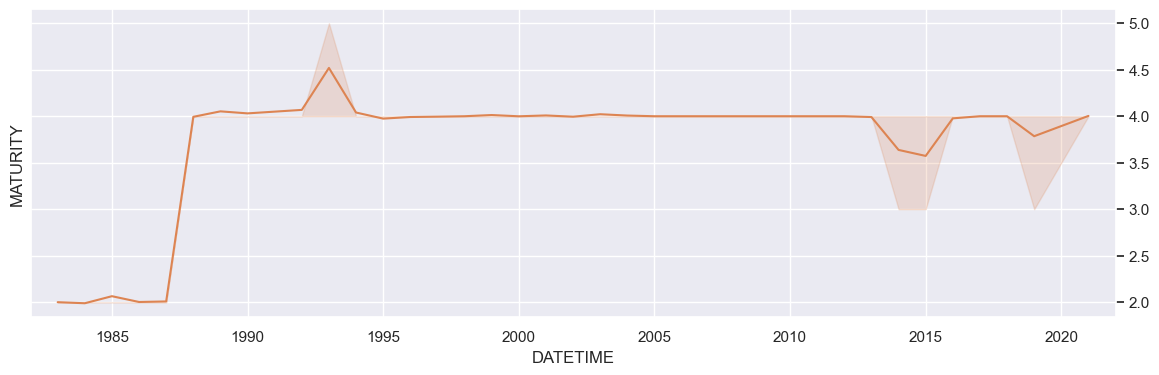




Feature:GONAD_WEIGHT

--------------------------------------------------
Data Info: GONAD_WEIGHT 

UNIQUE numbers, strings, blanks, null = (809, 0, 0, 1)
number of numeric = 17940
number of strings = 0
number of blanks = 0
number of null =  18972
check:  36912 == 36912

--------------------------------------------------
Histogram: GONAD_WEIGHT


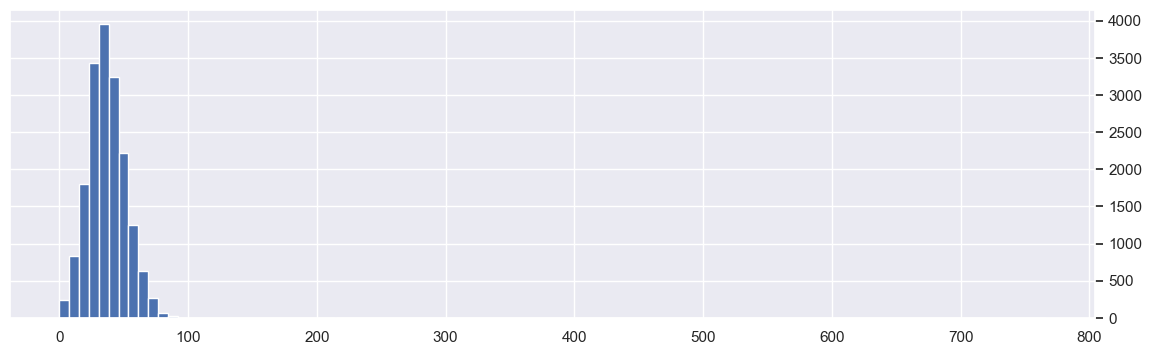


------------------------------------------------
Time Series:GONAD_WEIGHT
NUMERICAL


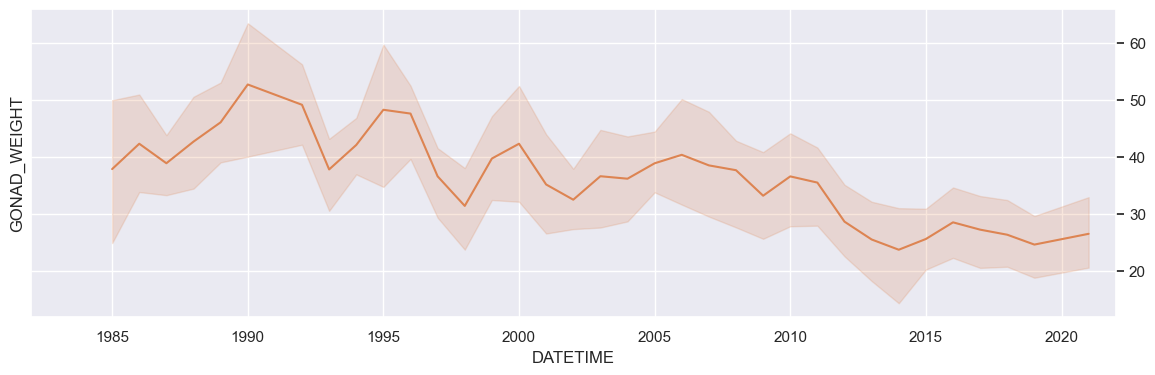




Feature:AGER_1

--------------------------------------------------
Data Info: AGER_1 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 7118
number of blanks = 0
number of null =  29794
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_1


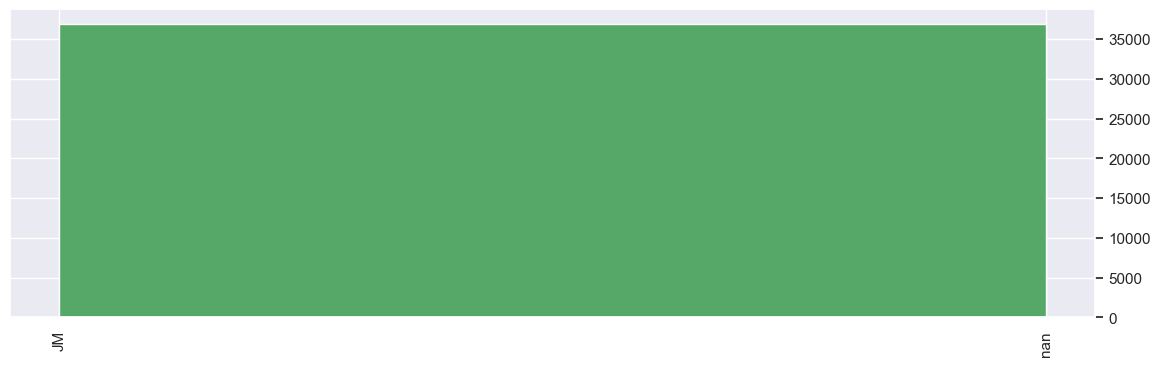


------------------------------------------------
Time Series:AGER_1
CATEGORICAL


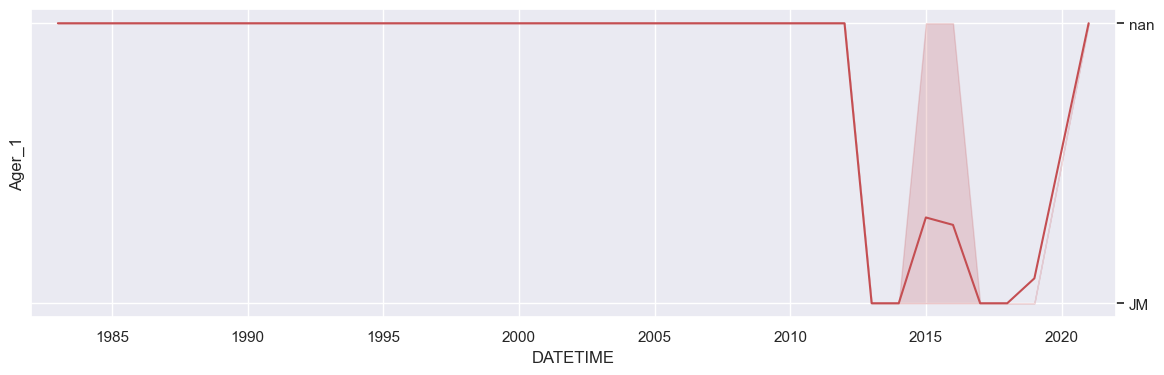




Feature:AGE_1

--------------------------------------------------
Data Info: AGE_1 

UNIQUE numbers, strings, blanks, null = (11, 0, 0, 1)
number of numeric = 31480
number of strings = 0
number of blanks = 0
number of null =  5432
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_1


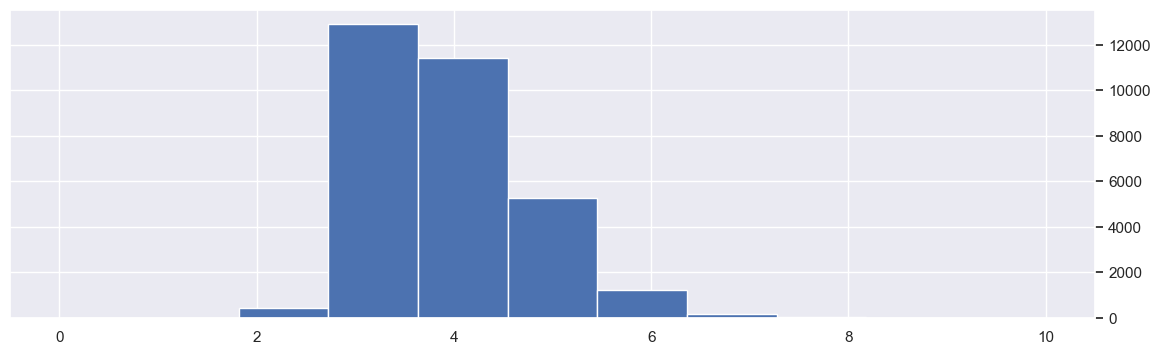


------------------------------------------------
Time Series:AGE_1
NUMERICAL


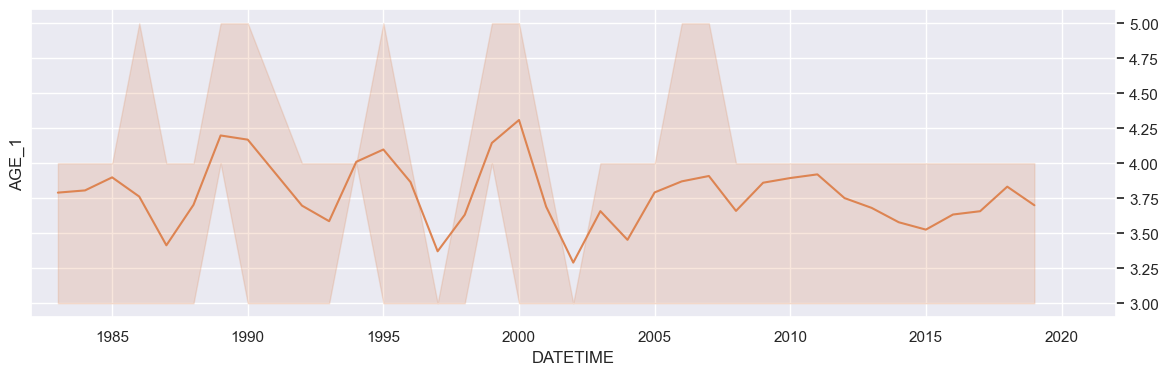




Feature:FSP_1

--------------------------------------------------
Data Info: FSP_1 

UNIQUE numbers, strings, blanks, null = (10, 0, 0, 1)
number of numeric = 31257
number of strings = 0
number of blanks = 0
number of null =  5655
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_1


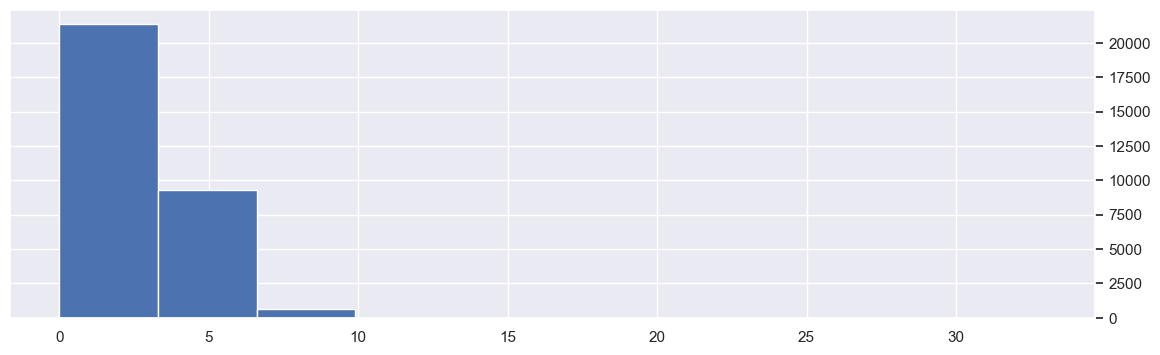


------------------------------------------------
Time Series:FSP_1
NUMERICAL


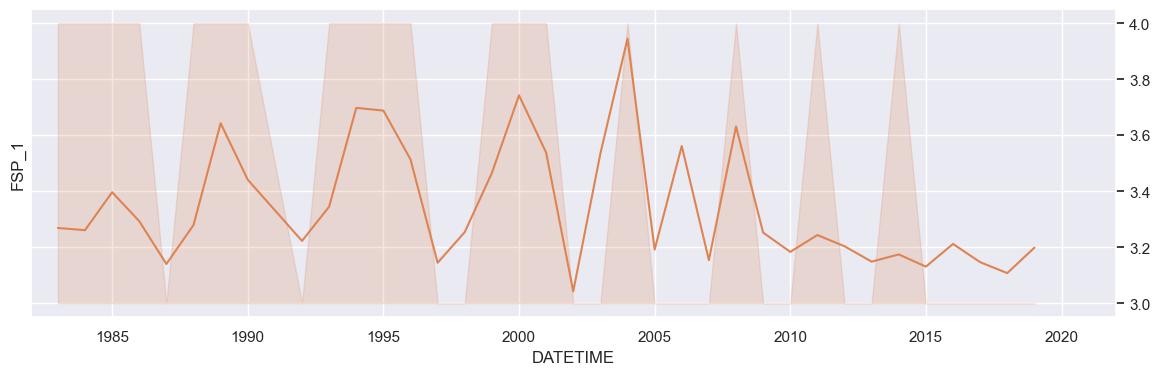




Feature:AGER_2

--------------------------------------------------
Data Info: AGER_2 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 1683
number of blanks = 0
number of null =  35229
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_2


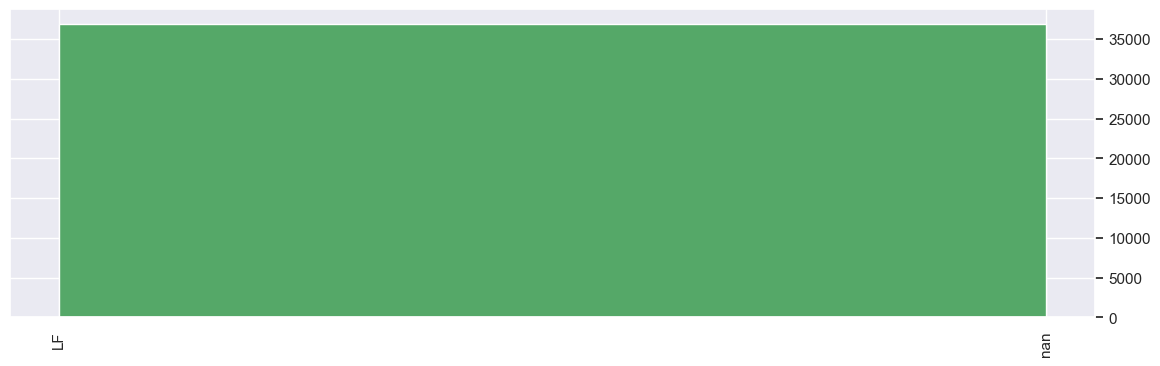


------------------------------------------------
Time Series:AGER_2
CATEGORICAL


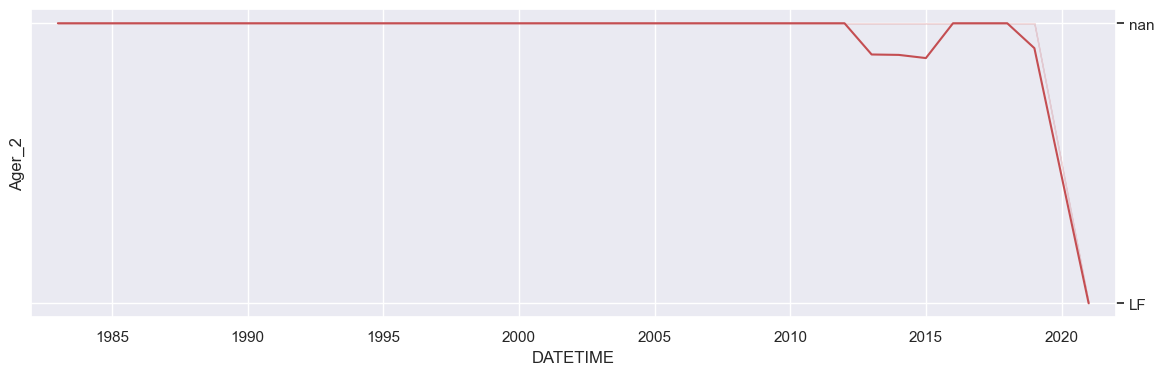




Feature:AGE_2

--------------------------------------------------
Data Info: AGE_2 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 1629
number of strings = 0
number of blanks = 0
number of null =  35283
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_2


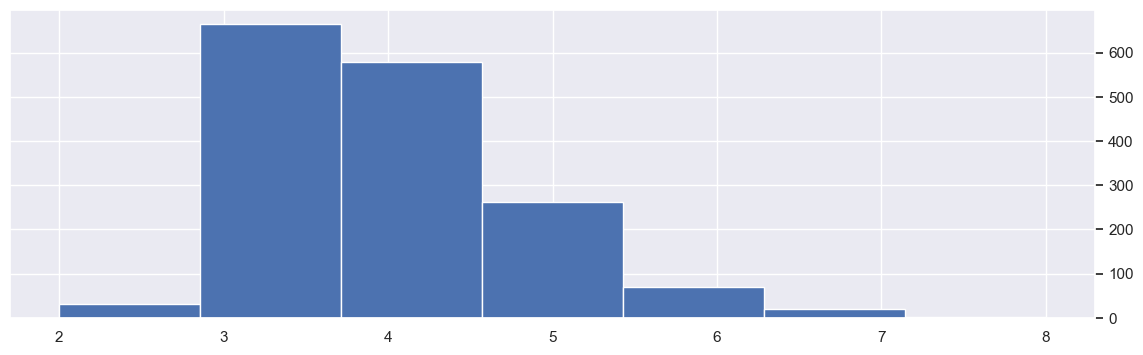


------------------------------------------------
Time Series:AGE_2
NUMERICAL


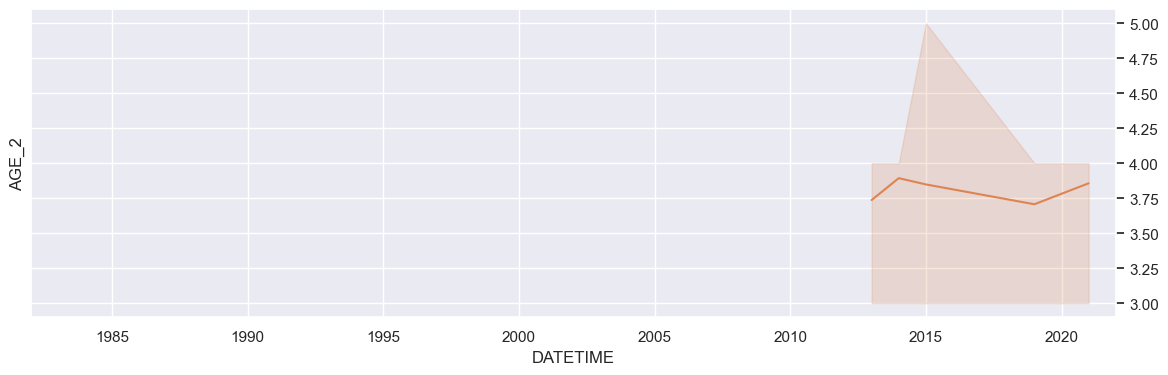




Feature:FSP_2

--------------------------------------------------
Data Info: FSP_2 

UNIQUE numbers, strings, blanks, null = (4, 0, 0, 1)
number of numeric = 1629
number of strings = 0
number of blanks = 0
number of null =  35283
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_2


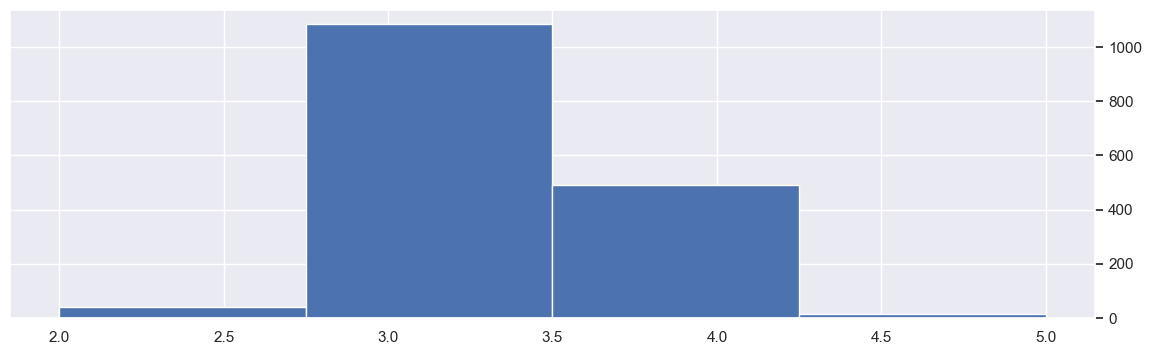


------------------------------------------------
Time Series:FSP_2
NUMERICAL


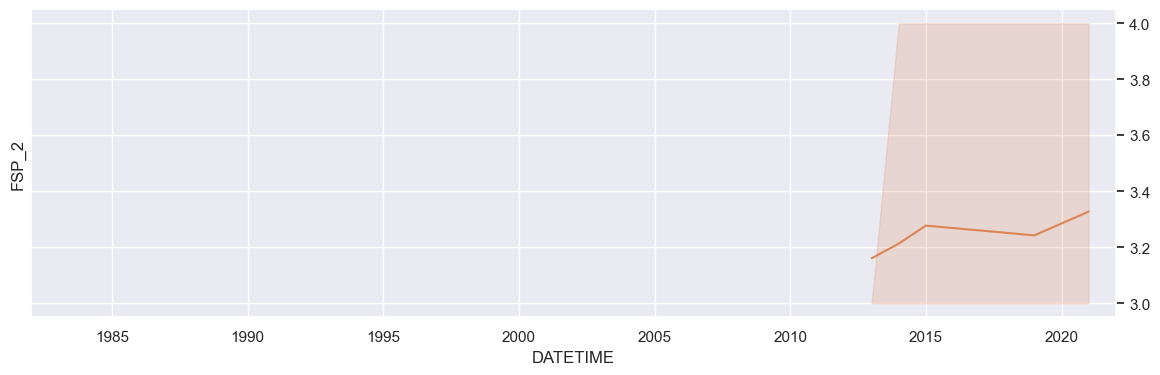




Feature:AGER_3

--------------------------------------------------
Data Info: AGER_3 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 2220
number of blanks = 0
number of null =  34692
check:  36912 == 36912

--------------------------------------------------
Histogram: AGER_3


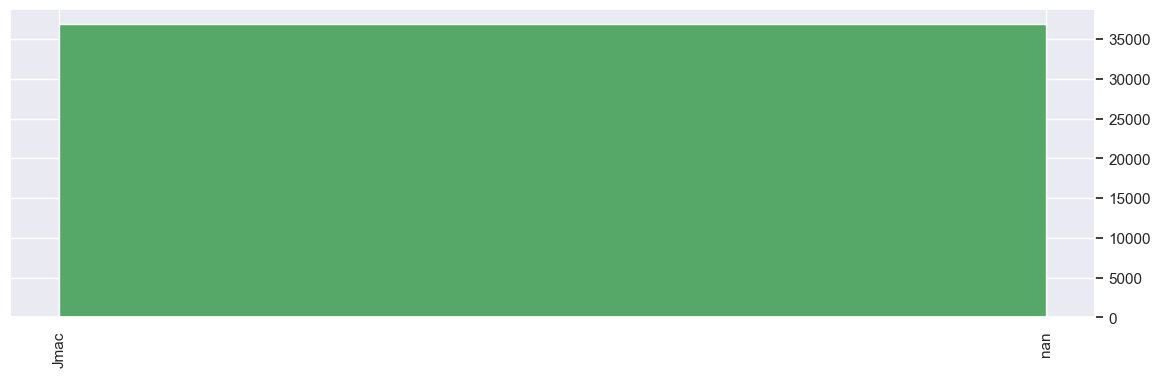


------------------------------------------------
Time Series:AGER_3
CATEGORICAL


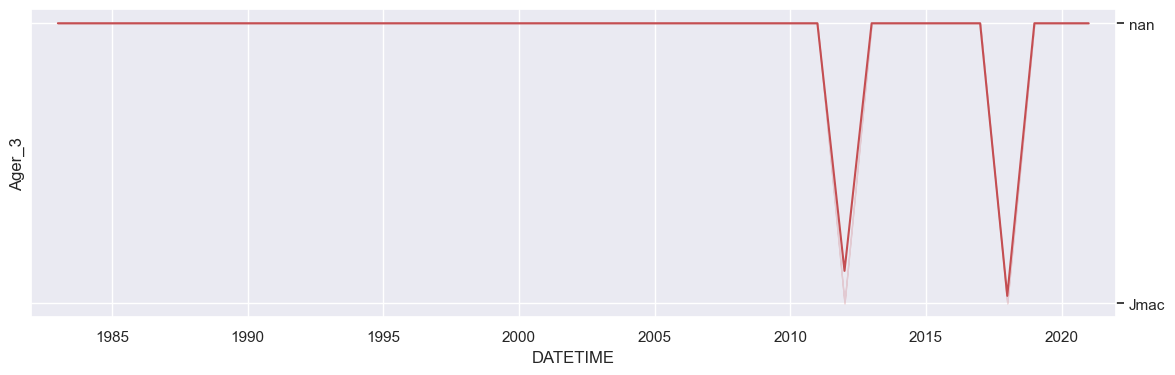




Feature:AGE_3

--------------------------------------------------
Data Info: AGE_3 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 2044
number of strings = 0
number of blanks = 0
number of null =  34868
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_3


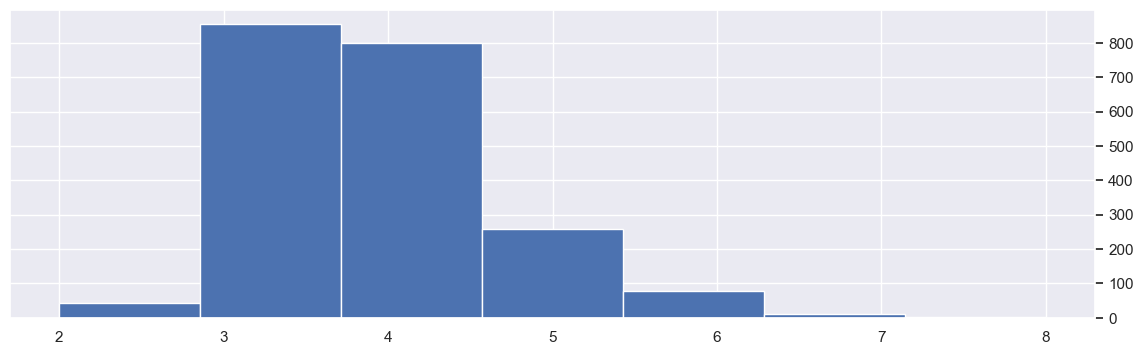


------------------------------------------------
Time Series:AGE_3
NUMERICAL


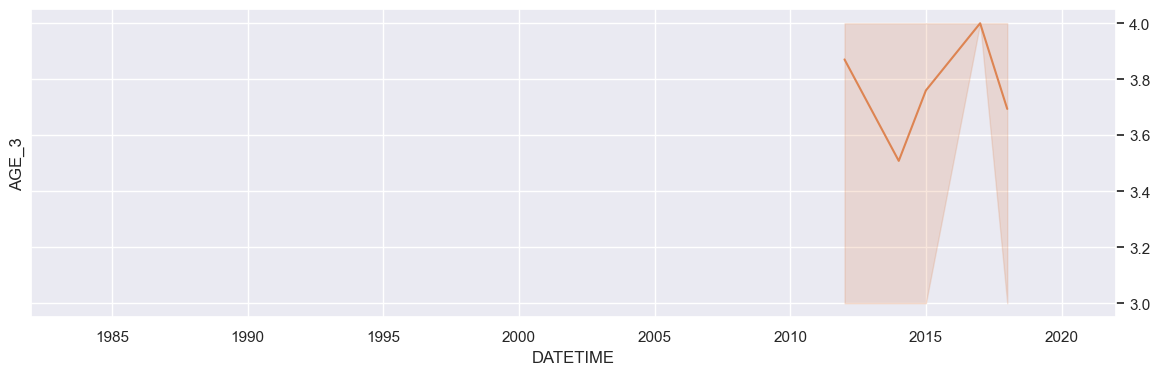




Feature:FSP_3

--------------------------------------------------
Data Info: FSP_3 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 2043
number of strings = 0
number of blanks = 0
number of null =  34869
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_3


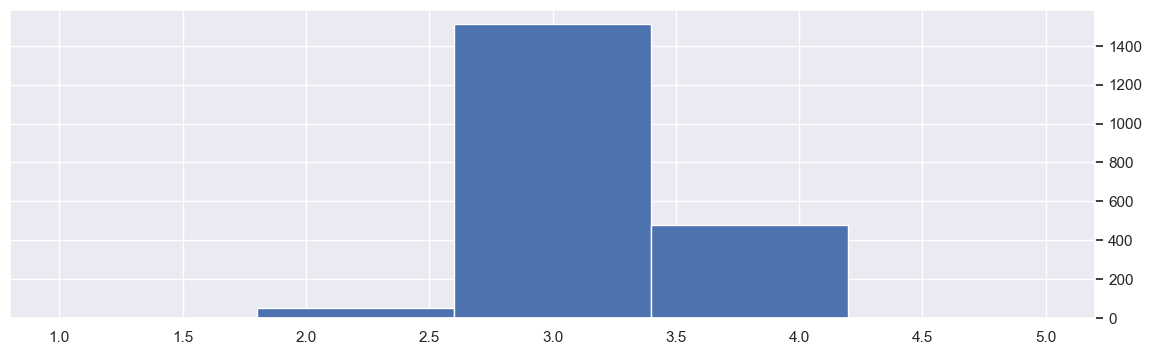


------------------------------------------------
Time Series:FSP_3
NUMERICAL


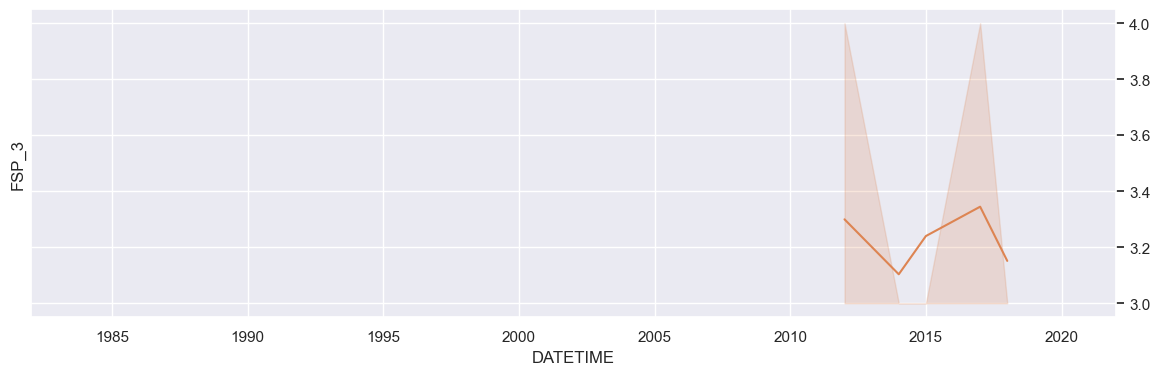




Feature:AGE_NOTES_1

--------------------------------------------------
Data Info: AGE_NOTES_1 

UNIQUE numbers, strings, blanks, null = (11, 13, 0, 1)
number of numeric = 31480
number of strings = 88
number of blanks = 0
number of null =  5344
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_NOTES_1


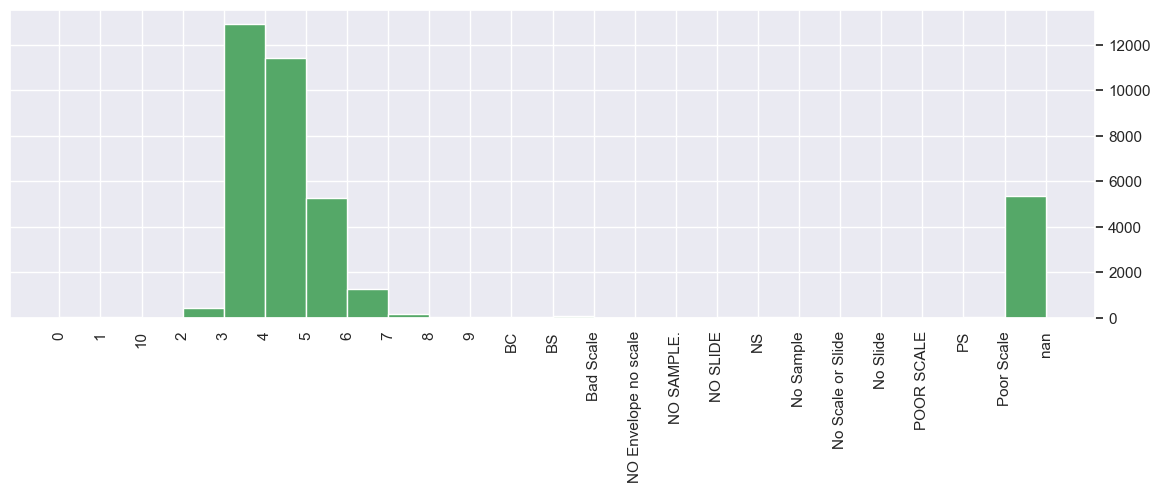


------------------------------------------------
Time Series:AGE_NOTES_1
CATEGORICAL


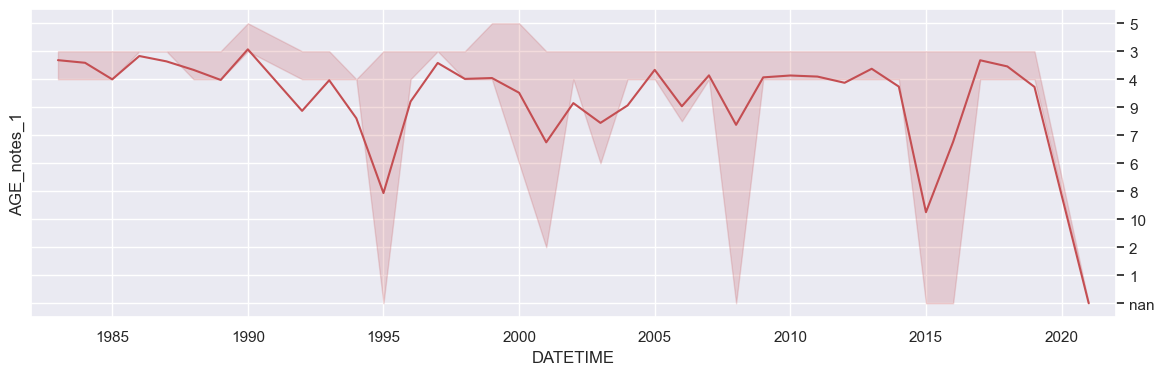




Feature:FSP_NOTES_1

--------------------------------------------------
Data Info: FSP_NOTES_1 

UNIQUE numbers, strings, blanks, null = (10, 16, 1, 1)
number of numeric = 31257
number of strings = 93
number of blanks = 1
number of null =  5562
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_NOTES_1


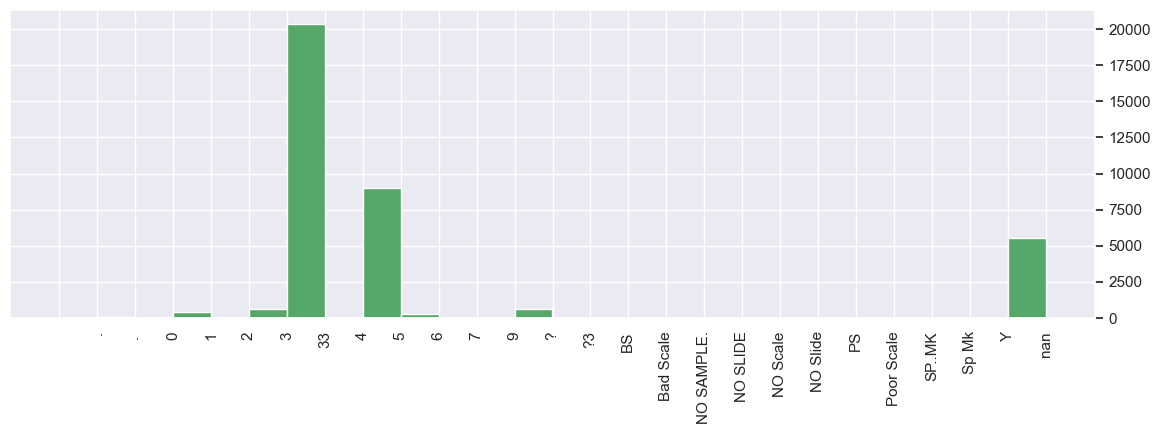


------------------------------------------------
Time Series:FSP_NOTES_1
CATEGORICAL


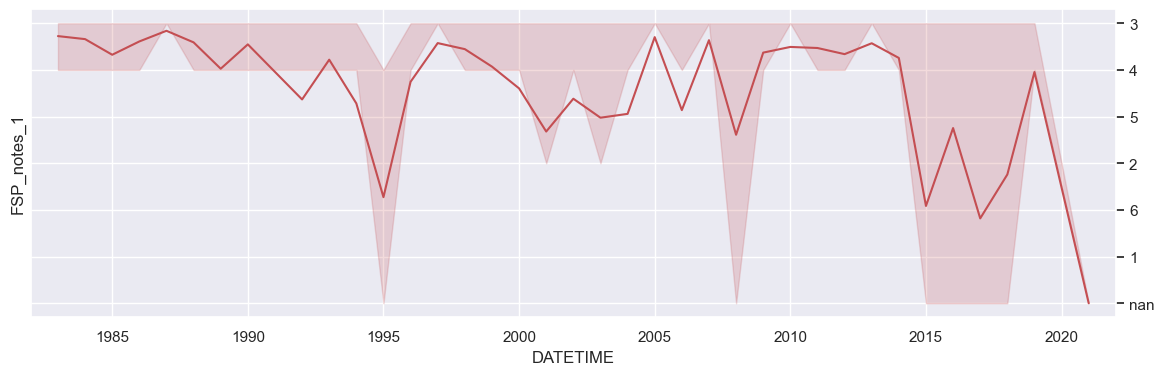




Feature:AGE_NOTES_2

--------------------------------------------------
Data Info: AGE_NOTES_2 

UNIQUE numbers, strings, blanks, null = (7, 1, 0, 1)
number of numeric = 1629
number of strings = 53
number of blanks = 0
number of null =  35230
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_NOTES_2


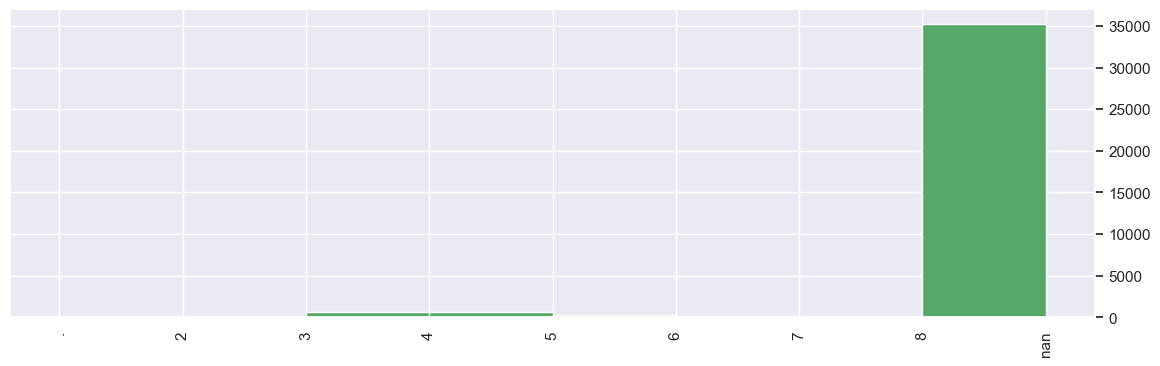


------------------------------------------------
Time Series:AGE_NOTES_2
CATEGORICAL


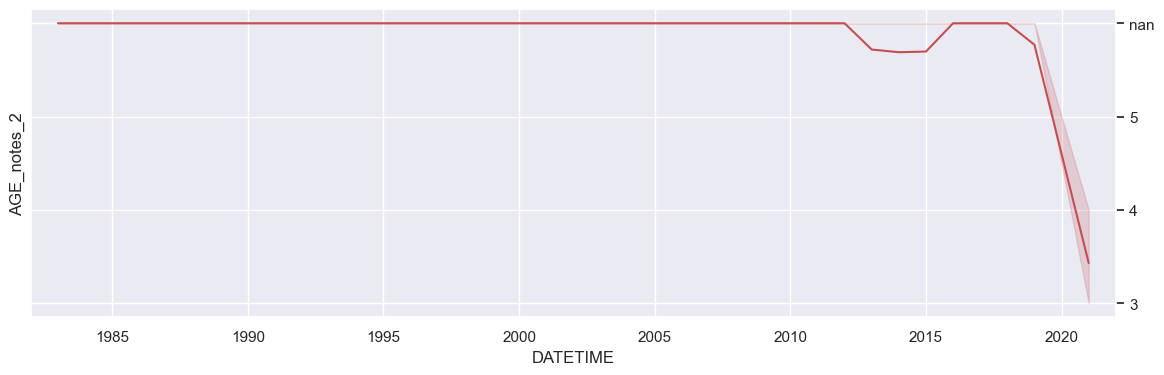




Feature:FSP_NOTES_2

--------------------------------------------------
Data Info: FSP_NOTES_2 

UNIQUE numbers, strings, blanks, null = (4, 1, 0, 1)
number of numeric = 1629
number of strings = 53
number of blanks = 0
number of null =  35230
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_NOTES_2


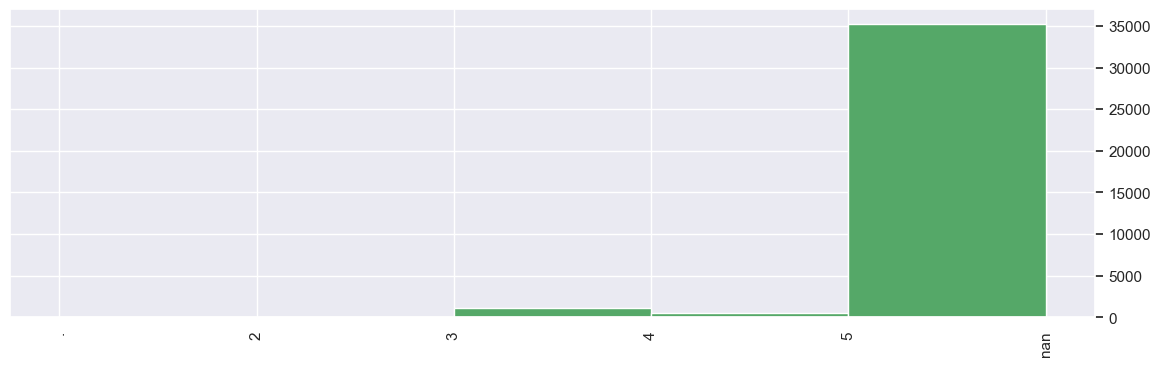


------------------------------------------------
Time Series:FSP_NOTES_2
CATEGORICAL


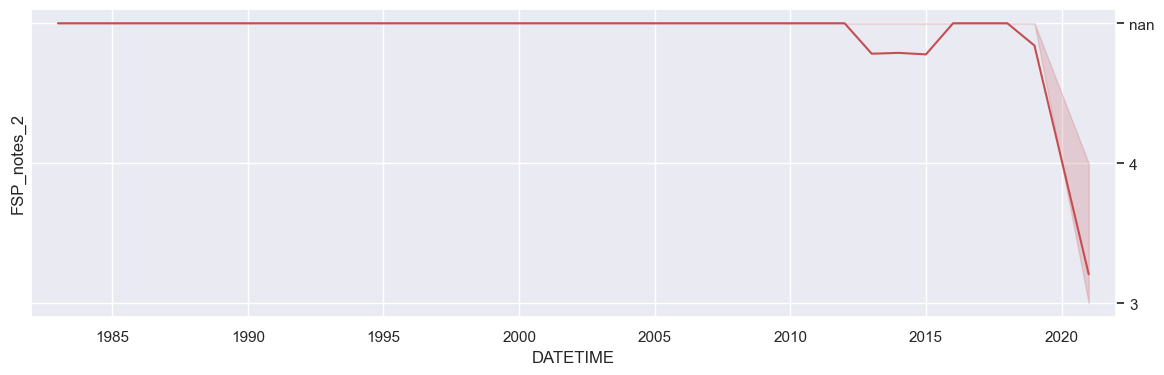




Feature:AGE_NOTES_3

--------------------------------------------------
Data Info: AGE_NOTES_3 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 2044
number of strings = 0
number of blanks = 0
number of null =  34868
check:  36912 == 36912

--------------------------------------------------
Histogram: AGE_NOTES_3


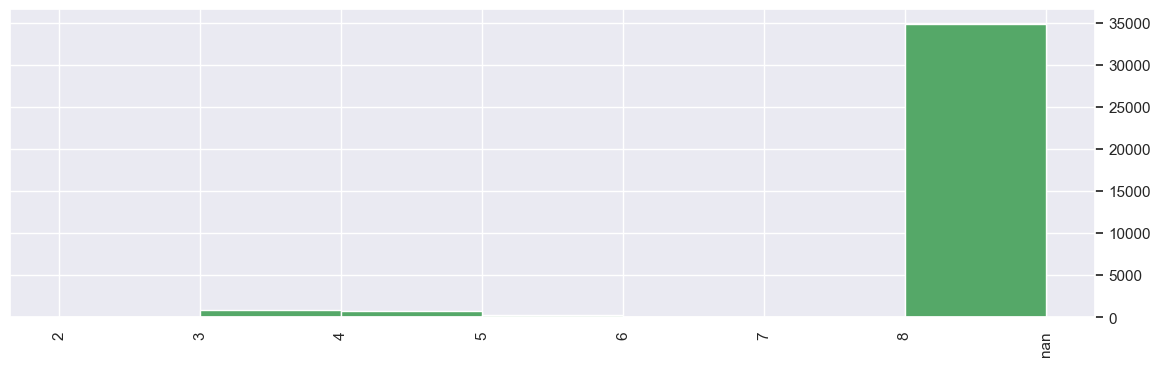


------------------------------------------------
Time Series:AGE_NOTES_3
NUMERICAL


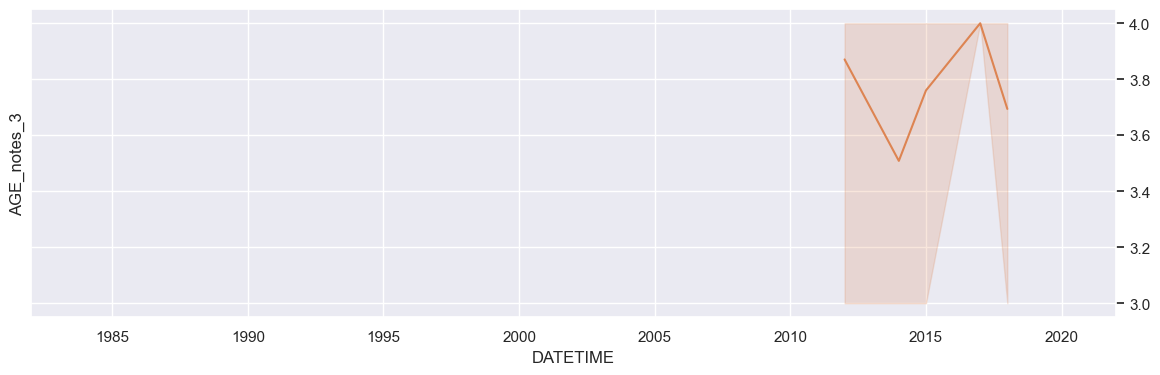




Feature:FSP_NOTES_3

--------------------------------------------------
Data Info: FSP_NOTES_3 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 2043
number of strings = 0
number of blanks = 0
number of null =  34869
check:  36912 == 36912

--------------------------------------------------
Histogram: FSP_NOTES_3


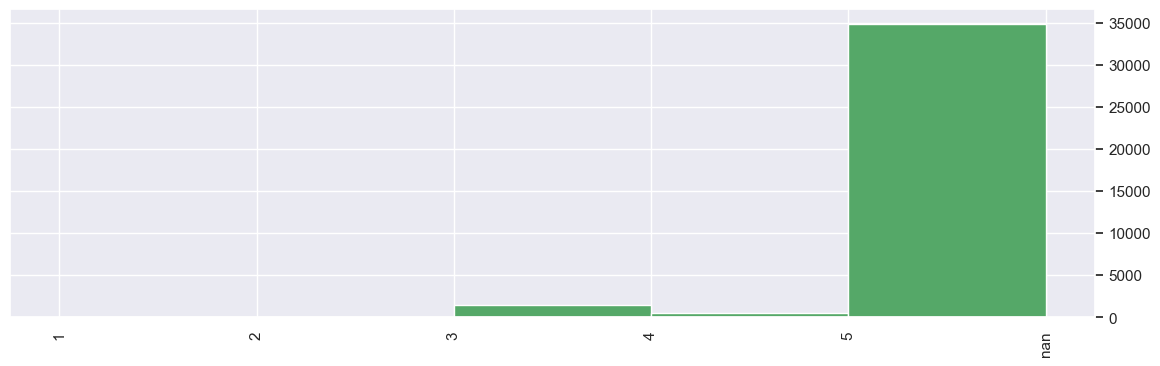


------------------------------------------------
Time Series:FSP_NOTES_3
NUMERICAL


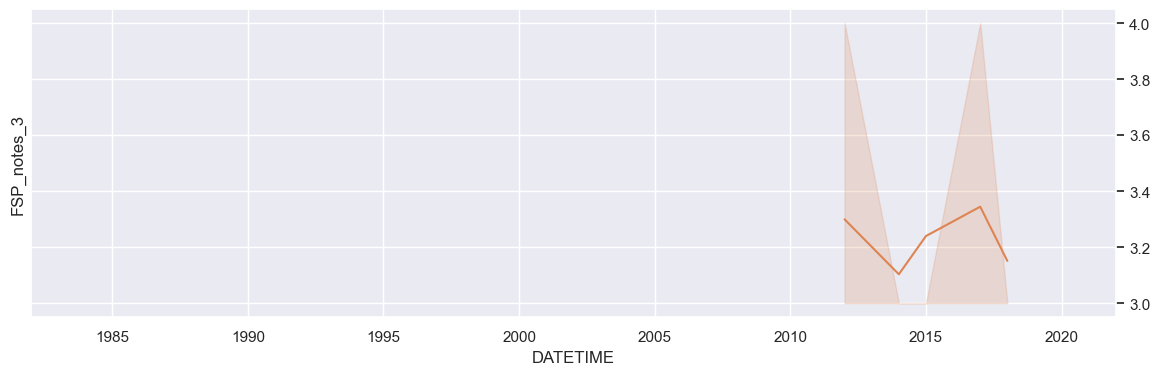




Feature:SITE_NOTES

--------------------------------------------------
Data Info: SITE_NOTES 

UNIQUE numbers, strings, blanks, null = (39, 41, 0, 0)
number of numeric = 35072
number of strings = 1840
number of blanks = 0
number of null =  0
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE_NOTES


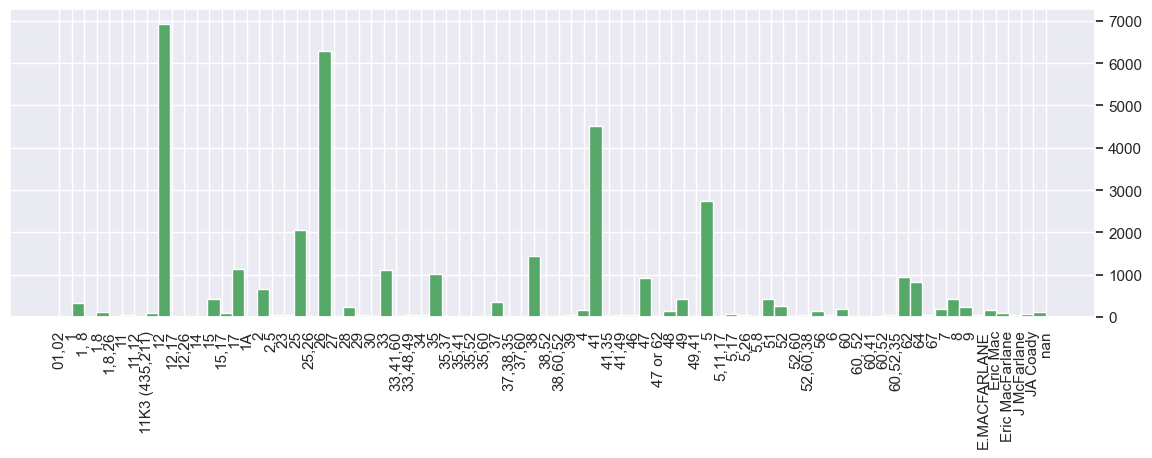


------------------------------------------------
Time Series:SITE_NOTES
CATEGORICAL


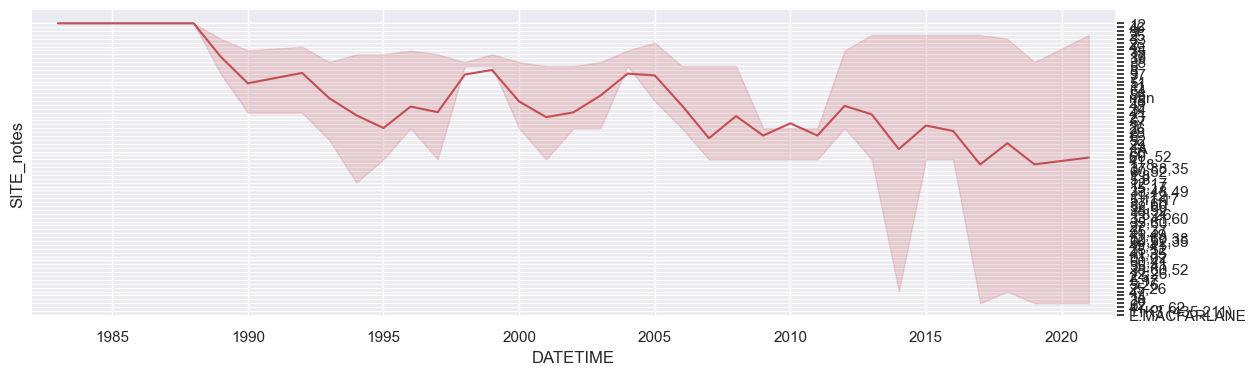




Feature:SITE1

--------------------------------------------------
Data Info: SITE1 

UNIQUE numbers, strings, blanks, null = (40, 8, 0, 0)
number of numeric = 36320
number of strings = 592
number of blanks = 0
number of null =  0
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE1


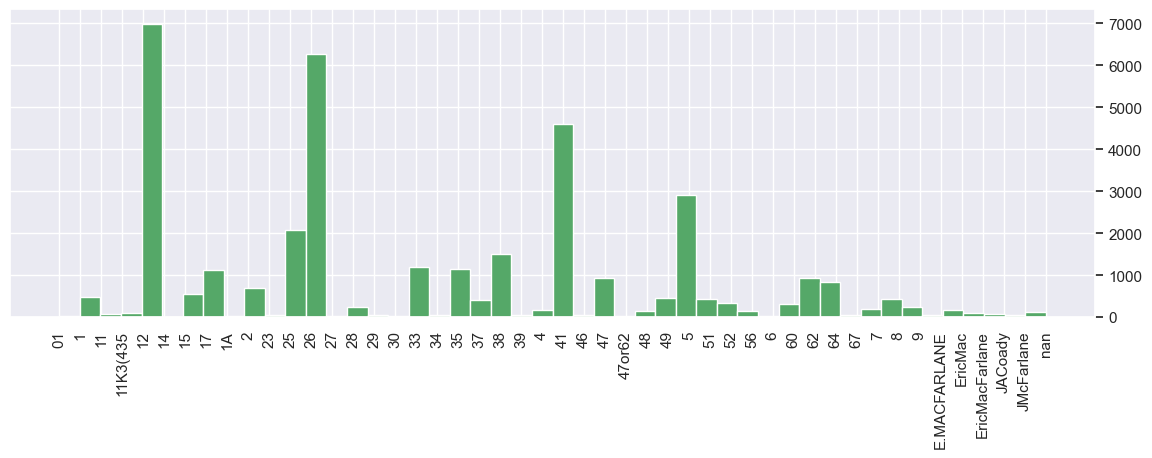


------------------------------------------------
Time Series:SITE1
CATEGORICAL


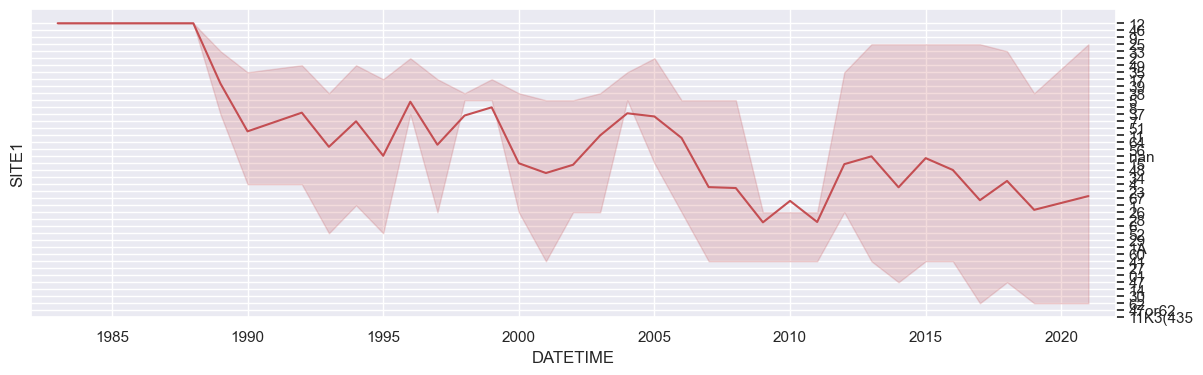




Feature:SITE2

--------------------------------------------------
Data Info: SITE2 

UNIQUE numbers, strings, blanks, null = (15, 1, 0, 1)
number of numeric = 1248
number of strings = 92
number of blanks = 0
number of null =  35572
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE2


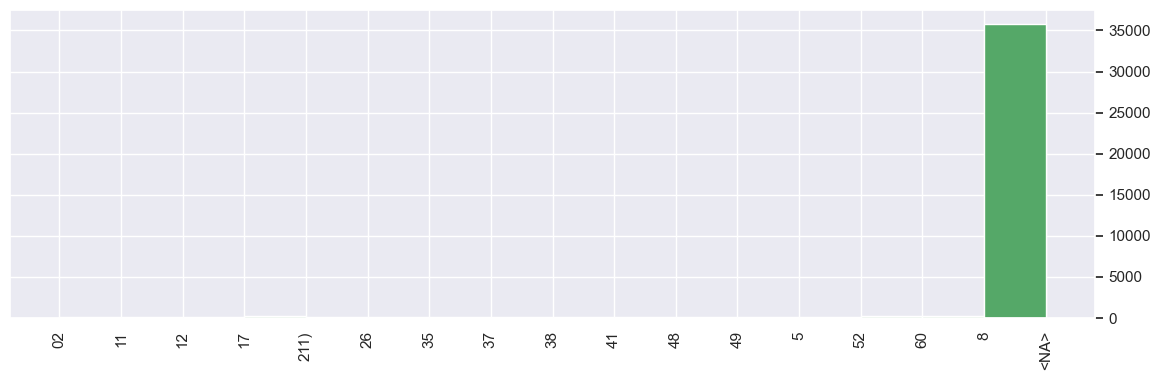


------------------------------------------------
Time Series:SITE2
CATEGORICAL


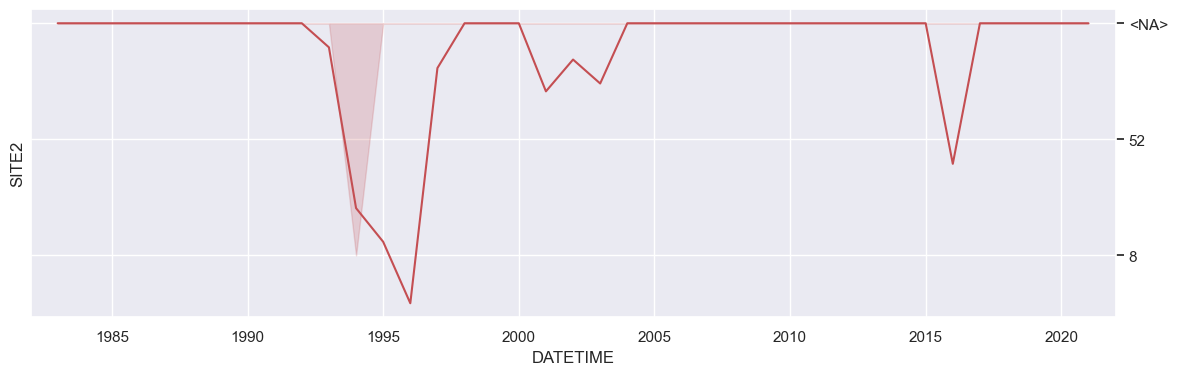




Feature:SITE3

--------------------------------------------------
Data Info: SITE3 

UNIQUE numbers, strings, blanks, null = (7, 0, 0, 1)
number of numeric = 280
number of strings = 0
number of blanks = 0
number of null =  36632
check:  36912 == 36912

--------------------------------------------------
Histogram: SITE3


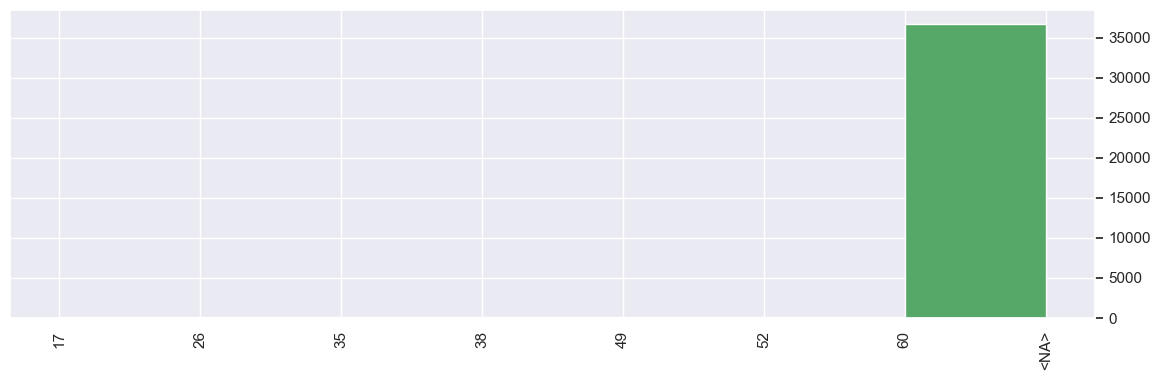


------------------------------------------------
Time Series:SITE3
CATEGORICAL


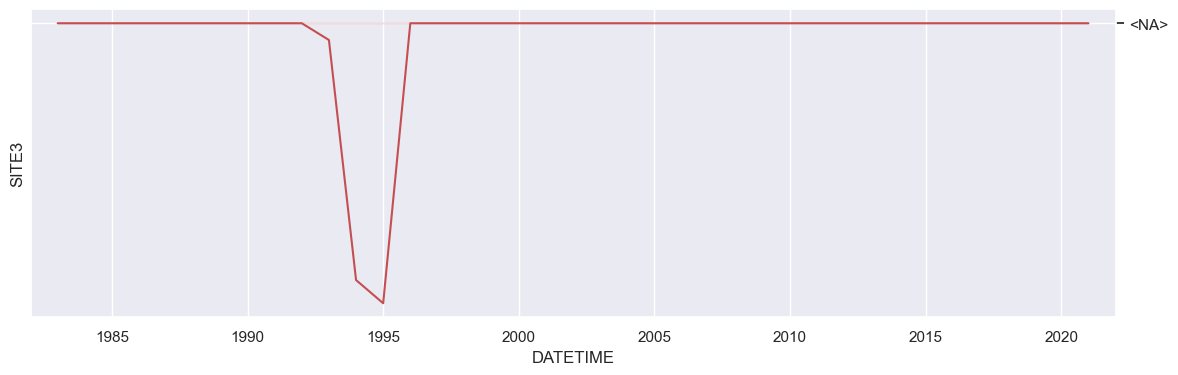

In [13]:
for col in col_to_plot:
    print('\n\n================================================================\n\nFeature:', col.upper(), sep='')
    do_EDA_stuff(df_FD, col)

# Questions/Issues From EDA Plots:
* naming issues
    * PERIOD
    * CONDITION
    * SEX
    * MATURITY
* outlier issues
    * FL_WET
    * FL_FROZEN
    * FL_STD
    * WEIGHT
    * GONAD_WEIGHT
* int vs float issues
    * FL_STD 
        * looks like a conversion issue (frozen to std likely)
        * should be INT, but has extremely precise float value
* 
* 
* 